# Introduction

L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts et fait appel aux services de votre entreprise. Cette base de données open source est mise à la disposition de particuliers et d’organisations afin de leur permettre de connaître la qualité nutritionnelle de produits. 

Aujourd’hui, pour ajouter un produit à la base de données d'Open Food Facts, il est nécessaire de remplir de nombreux champs textuels et numériques, ce qui peut conduire à des erreurs de saisie et à des valeurs manquantes dans la base. 

L’agence Santé publique France confie à votre entreprise la création d’un système de suggestion ou d’auto-complétion pour aider les usagers à remplir plus efficacement la base de données. Dans un premier temps, vous devez vous concentrer sur la prise en main des données, et d’abord les nettoyer et les explorer. 

Vous êtes missionné sur le projet de nettoyage et exploration des données en interne, afin de déterminer la faisabilité de cette idée d’application de Santé publique France. Voici le mail de briefing de la part d’une de vos collègues, Alma, qui était en contact direct avec le client :

Bonjour, 

Le jeu de données Open Food Facts est disponible sur le site officiel (ou disponible à ce lien en téléchargement). Les variables sont définies à cette adresse. Les champs sont séparés en quatre sections :

Les informations générales sur la fiche du produit : nom, date de modification, etc.
Un ensemble de tags : catégorie du produit, localisation, origine, etc.
Les ingrédients composant les produits et leurs additifs éventuels
Des informations nutritionnelles : quantité en grammes d’un nutriment pour 100 grammes du produit
Afin de simplifier ton approche, je te propose de commencer par établir la faisabilité de suggérer les valeurs manquantes pour une variable dont plus de 50% des valeurs sont manquantes.

Voici les différentes étapes pour nettoyer et explorer les données :

1) Traiter le jeu de données

Repérer des variables pertinentes pour les traitements à venir, et nécessaires pour suggérer des valeurs manquantes,.
Nettoyer les données en :
mettant en évidence les éventuelles valeurs manquantes parmi les variables pertinentes sélectionnées, avec au moins 3 méthodes de traitement adaptées aux variables concernées,
identifiant et en traitant les éventuelles valeurs aberrantes de chaque variable.
Automatiser ces traitements pour éviter de répéter ces opérations
Attention, le client souhaite que le programme fonctionne si la base de données est légèrement modifiée (ajout d’entrées, par exemple) !

2) Tout au long de l’analyse, produire des visualisations afin de mieux comprendre les données. Effectuer une analyse univariée pour chaque variable intéressante, afin de synthétiser son comportement.

Et un mot à ce sujet : le client nous demande de réaliser une présentation qui permet d’expliquer les analyses faites à un public néophyte. Sois donc attentif à la lisibilité : taille des textes, choix des couleurs, netteté suffisante, et variez les graphiques (boxplots, histogrammes, diagrammes circulaires, nuages de points…) pour illustrer au mieux ton propos.

3) Sélectionner / créer des variables à l’aide d’une analyse multivariée. Effectuer les tests statistiques appropriés pour vérifier la significativité des résultats.

4) Rédiger un rapport d’exploration et une conclusion pour expliquer la faisabilité de l’application demandée.

5) Même si les données n’incluent pas de données personnelles, on doit expliquer dans une présentation en quoi ce projet respecte les 5 grands principes du RGPD. Santé publique France aimerait publier quelque chose sur le site Open Food Facts pour couper court aux questions sur le respect des RGPD que nous recevons parfois. 

# Import des librairies

In [387]:
import sys
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

# Lecture du dataset

## Lecture du fichier csv

Sur le site <a href="https://world.openfoodfacts.org/">Open Food Facts</a>, nous avons pu constaté que le séparateur est la tabulation et le format UTF-8

In [8]:
products = pd.read_csv("./data/fr.openfoodfacts.org.products.csv", sep="\t", encoding = 'utf8', low_memory=False)

## Affichage des caractéristiques du fichier

In [10]:
products.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Affichons les informations du dataframe :

In [12]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


Affichons le nombre de valeurs présentes par colonnes :

<Axes: >

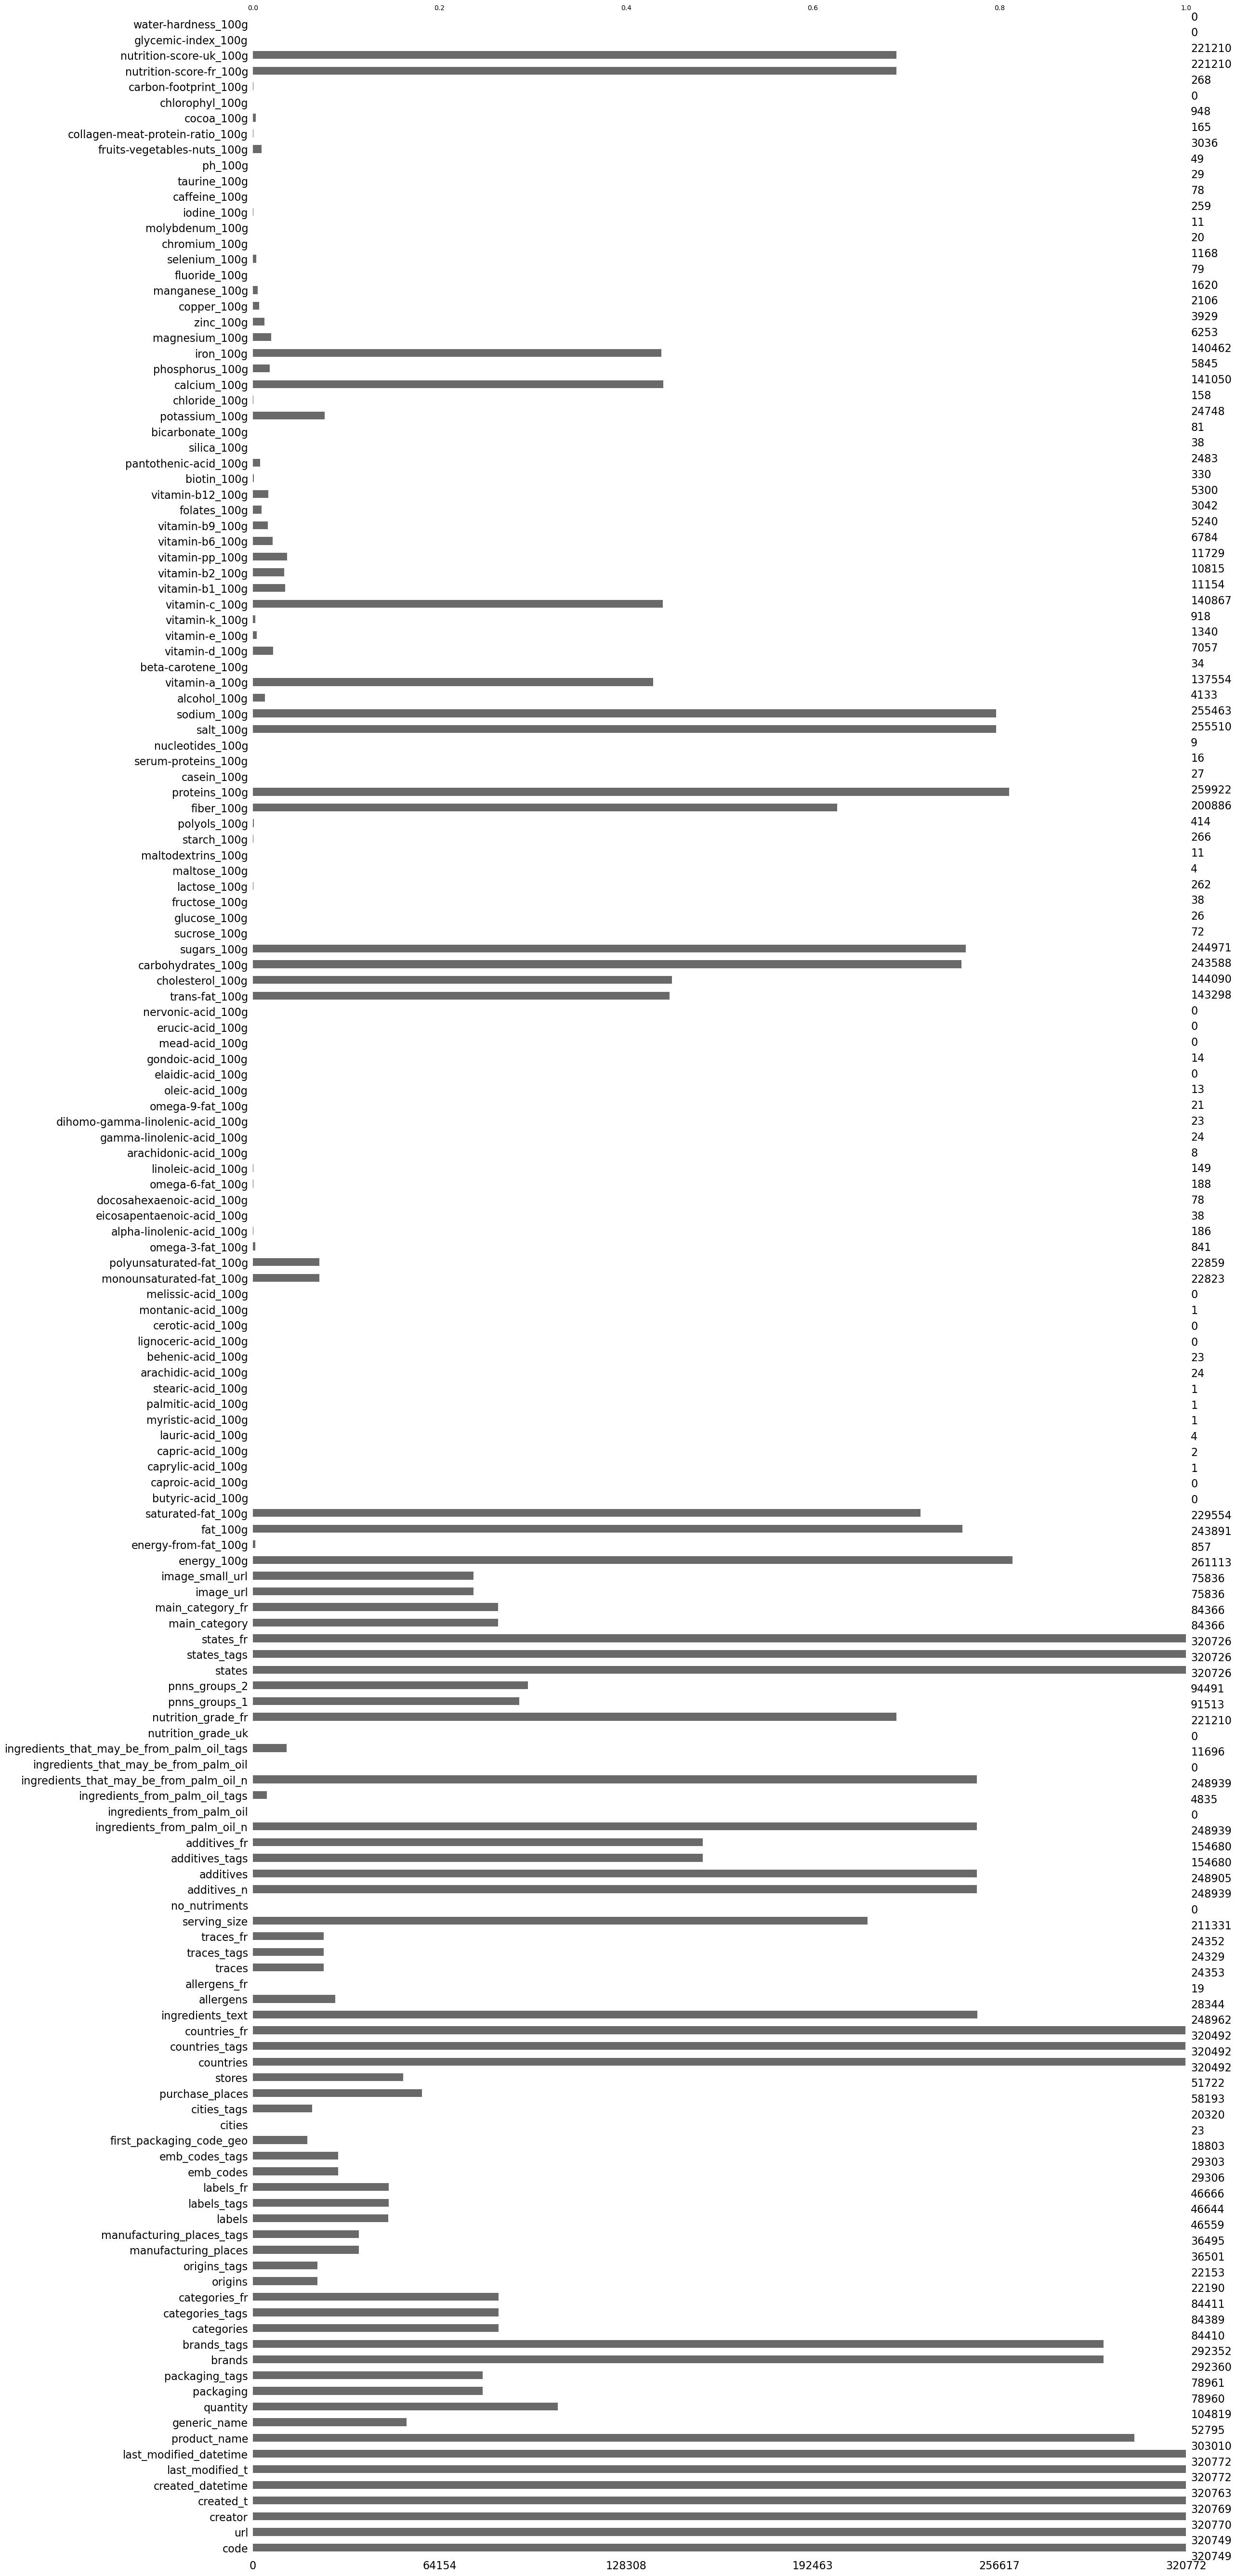

In [14]:
msno.bar(products)

Supprimons tout d'abord les variables avec trop peu de données afin de faciliter les sélections à venir.

Pour cela, nous allons tout d'abord calculer un taux de remplissage des différentes variables.

In [16]:
# Création d'une liste avec le nombre de valeurs manquantes par colonnes
liste_nan = products.isnull().sum().reset_index() 
# Récupération du nombre de lignes du dataset, représentant le nombre de valeurs maximum
nombre_valeurs = products.shape[0]

# Création d'un dataframe pour stocker nos données
df_nan = pd.DataFrame(liste_nan)
df_nan.rename(columns={0 : "valeurs"}, inplace=True)
# Modification de la valeur en pourcentage
df_nan["valeurs"] = 100 - (df_nan["valeurs"] * 100 / nombre_valeurs)

Affichons la répartition des valeurs de notre dataframe

Text(0.5, 1.0, 'Distribution des valeurs de remplissage')

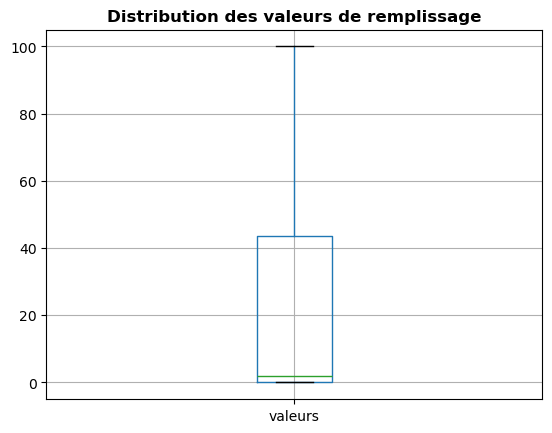

In [18]:
df_nan.boxplot()
plt.title("Distribution des valeurs de remplissage", fontweight="bold")

D'après la distribution du pourcentage de valeurs manquantes, nous choisissons de supprimer toutes les colonnes dont le taux de remplissage est inférieur à la valeur médiane.

In [20]:
limite_remplissage = df_nan["valeurs"].median()

variables_vides = df_nan.loc[df_nan["valeurs"] < limite_remplissage, "index"].to_list()
products.drop(variables_vides, axis=1, inplace=True)

In [21]:
products.shape

(320772, 81)

Nous pouvons constater que 81 (162 colonnes initiales moins 81 colonnes restantes) colonnes ont été supprimées.

## Affichage des colonnes pour repérer les variables pertinentes

On augmente le nombre de colonnes affichées pour voir l'intégralité des informations.

In [25]:
pd.set_option("display.max_rows", 90)

On affiche les colonnes avec la méthode dtypes, qui permet également d'avoir un aperçu des types des variables.

In [27]:
products.dtypes

code                                           object
url                                            object
creator                                        object
created_t                                      object
created_datetime                               object
last_modified_t                                object
last_modified_datetime                         object
product_name                                   object
generic_name                                   object
quantity                                       object
packaging                                      object
packaging_tags                                 object
brands                                         object
brands_tags                                    object
categories                                     object
categories_tags                                object
categories_fr                                  object
origins                                        object
origins_tags                

Nous pouvons constater la présence de plusieurs variables présentant les même informations de manière différente.

Par exemple, les colonnes "created_t" et "created_datetime".

Simplifions ces différentes colonnes, comme suit, d'après la documentation du dataset :
- les colonnes "last_modified_t" et "last_modified_datetime" ne seront pas utile pour notre étude
- les colonnes "created_t" et "last_modified_datetime" ne seront pas utile pour notre étude
- les colonnes finissant par "_tags" présentent la même information que les mêmes colonnes sans le suffixe
- les colonnes finissant par "_t" présentent un timestamp, alors que les colonnes finissant par "_datetime" présentent les dates en format ISO8601
- les colonnes finissant par "_fr" présentent la même information que les colonnes sans le suffixe mais en français
- les colonnes "images" ne nous serviront pas pour l'étude
- la colonne "additives_n" ne présente que le nombre d'additifs
- la colonne "creator" est supprimée pour éviter toute confusion au sujet de la RGPD

In [29]:
liste_colonnes = products.columns.to_list()

colonnes_a_supprimer = []
for i in range(len(liste_colonnes)) :
    if "created" in liste_colonnes[i] :
        colonnes_a_supprimer.append(liste_colonnes[i])
    if "last_modified" in liste_colonnes[i] :
        colonnes_a_supprimer.append(liste_colonnes[i])
    if "_tags" in liste_colonnes[i] :
        colonnes_a_supprimer.append(liste_colonnes[i])
    if "_datetime" in liste_colonnes[i] :
        colonnes_a_supprimer.append(liste_colonnes[i])
    if "_fr" in liste_colonnes[i] :
        colonnes_a_supprimer.append(liste_colonnes[i])
    if "images" in liste_colonnes[i] :
        colonnes_a_supprimer.append(liste_colonnes[i])
    if "additives_n" in liste_colonnes[i] :
        colonnes_a_supprimer.append(liste_colonnes[i])
    if "image" in liste_colonnes[i] :
        colonnes_a_supprimer.append(liste_colonnes[i])
    if "creator" in liste_colonnes[i] :
        colonnes_a_supprimer.append(liste_colonnes[i])

products.drop(colonnes_a_supprimer, axis=1, inplace=True)

In [30]:
products.shape

(320772, 50)

Notre dataframe contient à présent 50 colonnes, au lieu de 162 au départ.

Etant donné que nous aurons besoin de notre taux de remplissage pour la sélection de la cible et des features permettant d'en déterminer sa valeur, nous allons à présent simplifier le dataframe des taux de remplissage, en ne conservant que les features après simplification

In [33]:
df_nan = df_nan.loc[df_nan["index"].isin(products.columns.to_list()), :]

# Sélection de notre cible

Nous souhaitons que la cible soit une variable catégorielle avec un taux de remplissage de moins de 50%.

La cible sera donc de type "object" et avec un taux de remplissage < 50%.

In [36]:
liste_variables_categorielles = []
for i in range(len(products.columns.to_list())) :
    if products.dtypes.iloc[i] == "object" :
        liste_variables_categorielles.append(products.columns.to_list()[i])

In [37]:
df_nan.loc[(df_nan["index"].isin(liste_variables_categorielles))
    & (df_nan["valeurs"] <= 50), :]

,index,valeurs
8,generic_name,16.458731
9,quantity,32.677104
10,packaging,24.615615
14,categories,26.314641
17,origins,6.917686
19,manufacturing_places,11.379110
21,labels,14.514671
24,emb_codes,9.136084
26,first_packaging_code_geo,5.861796
29,purchase_places,18.141546


Nous pouvons constater que les deux variables "pnns_group" constituent une excellente cible.

De plus, après avoir recherché leur signification sur internet (celles-ci n'étant pas documentées dans le fichier d'aide du dataset), il apparait qu'elles correspondent au "Programme national nutrition santé", ce qui se marie parfaitement avec notre client.

# Vérification des doublons de produits

Nous allons à présent supprimer les doublons de produits, d'après leur nom ou leur code (code barre)

In [41]:
products = products.drop_duplicates(subset="product_name", keep="first")
products = products.drop_duplicates(subset="code", keep="first")

# Séparons la cible du reste de notre dataframe

Créons une dataframe pour stocker nos valeurs cibles

In [44]:
cible = products.loc[:, "pnns_groups_1"]

Supprimons la cible de notre dataframe

In [46]:
products = products.drop("pnns_groups_1", axis = 1)

# Sélection des features

Affichons tout d'abord le taux de remplissage des variables du dataframe

Text(0.5, 0, 'Taux de remplissage')

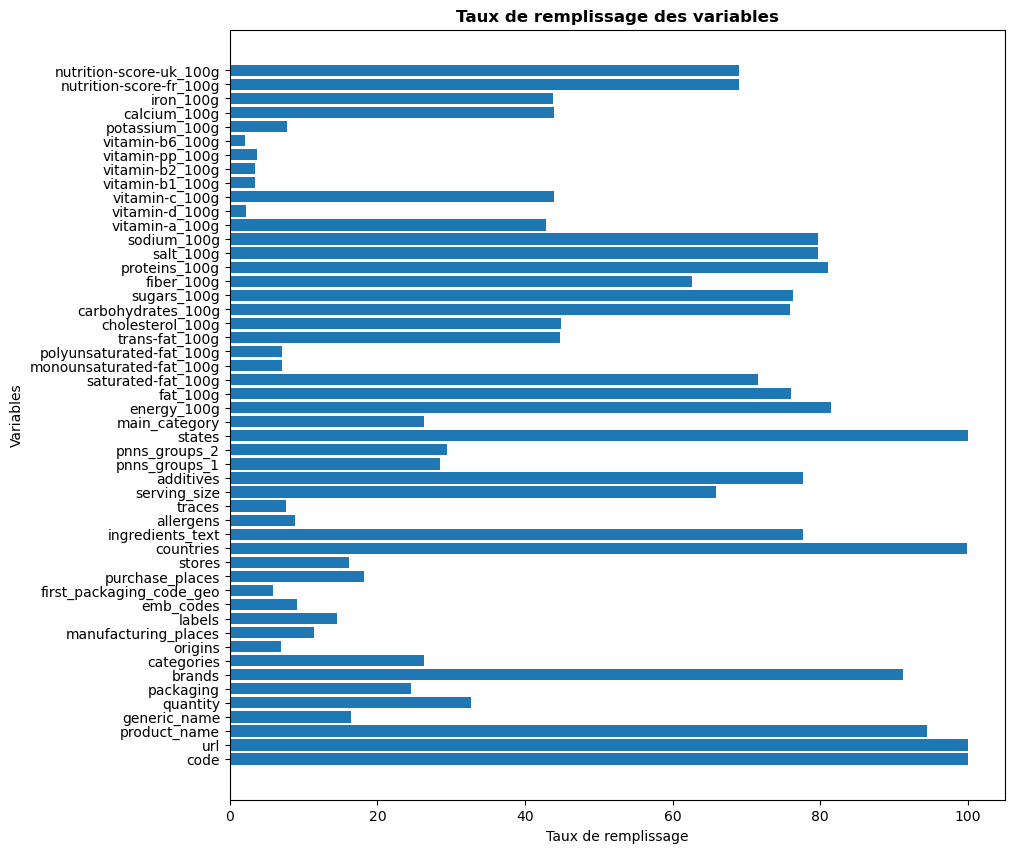

In [49]:
plt.figure(figsize=(10,10))
plt.barh(df_nan["index"], df_nan["valeurs"])
plt.title("Taux de remplissage des variables", fontweight="bold")
plt.ylabel("Variables")
plt.xlabel("Taux de remplissage")

Sélectionnons les features suffisamment remplies 

In [51]:
liste_features_potentielles = df_nan.loc[df_nan["valeurs"] >= 50, :]["index"].to_list()
liste_features_potentielles

['code',
 'url',
 'product_name',
 'brands',
 'countries',
 'ingredients_text',
 'serving_size',
 'additives',
 'states',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition-score-fr_100g',
 'nutrition-score-uk_100g']

Parmi les features restantes, nous ne conserverons pas :
- le code barre
- l'url
- le nom de produit
- la marque
- le pays
- la liste des ingrédients
- la taille de portion
- la liste des additifs
- l'état
- le score nutritif pour l'UK

In [53]:
liste_features_potentielles.remove("code")
liste_features_potentielles.remove("url")
liste_features_potentielles.remove("product_name")
liste_features_potentielles.remove("brands")
liste_features_potentielles.remove("countries")
liste_features_potentielles.remove("serving_size")
liste_features_potentielles.remove("states")
liste_features_potentielles.remove("nutrition-score-uk_100g")
liste_features_potentielles.remove("ingredients_text")
liste_features_potentielles.remove("additives")

In [54]:
liste_features_potentielles

['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition-score-fr_100g']

# Création d'une fonction pour automatiser les étapes de sélection

Afin de nous permettre d'effectuer notre sélection, nous allons créer une première fonction qui retournera 3 dataframes :
- Le premier est le dataframe d'oirigine simplifié (avec les pré-tris effectués et sans doublons)
- Le second contenant la liste des potentielles cibles, avec leur taux de remplissage
- Le troisième contenant la liste des potentielles features, avec leur taux de remplissage

In [57]:
products = pd.read_csv("./data/fr.openfoodfacts.org.products.csv", sep="\t", encoding = 'utf8', low_memory=False)

In [58]:
def selection_cible_features(products) :
    data = products.copy(deep=False)
    # Création d'une liste avec le nombre de valeurs manquantes par colonnes
    liste_nan = data.isnull().sum().reset_index() 
    # Récupération du nombre de lignes du dataset, représentant le nombre de valeurs maximum
    nombre_valeurs = data.shape[0]
    
    # Création d'un dataframe pour stocker nos données
    df_nan = pd.DataFrame(liste_nan)
    df_nan_debut = pd.DataFrame(liste_nan)
    df_nan.rename(columns={0 : "valeurs"}, inplace=True)
    # Modification de la valeur en pourcentage
    df_nan["valeurs"] = 100 - (df_nan["valeurs"] * 100 / nombre_valeurs)

    # Définition de la valeur limite de remplissage sur la valeur médiane des valeurs de remplissage (celle-ci pouvant avoir beaucoup d'outliers)
    limite_remplissage = df_nan["valeurs"].median()

    # Identification des variables à supprimer
    variables_vides = df_nan.loc[df_nan["valeurs"] < limite_remplissage, "index"].to_list()
    # Suppression des variables concernées dans le dataframe d'origine
    data.drop(variables_vides, axis=1, inplace=True)

    # Création d'une liste avec les noms de colonnes
    liste_colonnes = data.columns.to_list()

    # Stockage des variables à supprimer selon le schéma définit
    colonnes_a_supprimer = []
    for i in range(len(liste_colonnes)) :
        if "created" in liste_colonnes[i] :
            colonnes_a_supprimer.append(data.columns.to_list()[i])
        if "last_modified" in liste_colonnes[i] :
            colonnes_a_supprimer.append(data.columns.to_list()[i])
        if "_tags" in liste_colonnes[i] :
            colonnes_a_supprimer.append(data.columns.to_list()[i])
        if "_datetime" in liste_colonnes[i] :
            colonnes_a_supprimer.append(data.columns.to_list()[i])
        if "_fr" in liste_colonnes[i] :
            colonnes_a_supprimer.append(data.columns.to_list()[i])
        if "images" in liste_colonnes[i] :
            colonnes_a_supprimer.append(data.columns.to_list()[i])
        if "additives_n" in liste_colonnes[i] :
            colonnes_a_supprimer.append(data.columns.to_list()[i])
        if "image" in liste_colonnes[i] :
            colonnes_a_supprimer.append(data.columns.to_list()[i])
        if "creator" in liste_colonnes[i] :
            colonnes_a_supprimer.append(data.columns.to_list()[i])
    # Suppression des variables dans le dataframe d'origine
    data.drop(colonnes_a_supprimer, axis=1, inplace=True)
    # Suppression également dans le dataframe des taux de remplissage
    df_nan = df_nan.loc[df_nan["index"].isin(data.columns.to_list()), :]

    # Mise à jour de la liste des colonnes après suppresion
    liste_colonnes = data.columns.to_list()
    
    # Création d'une liste pour stocker uniquement les variables catégorielles, en vue de la sélection de la cible
    liste_variables_categorielles = []
    for i in range(len(liste_colonnes)) :
        if data.dtypes.iloc[i] == "object" :
            liste_variables_categorielles.append(liste_colonnes[i])

    # On stocke la liste des cibles pontentielles dans un dataframe
    df_cibles_pontentielles = df_nan.loc[(df_nan["index"].isin(liste_variables_categorielles))
        & (df_nan["valeurs"] <= 50), :]

    # On liste les features potentielles, c'est à dire celles avec un taux de remplissage > 50%
    df_features_potentielles = df_nan.loc[df_nan["valeurs"] >= 50, :]

    # On supprime de ce dataframe les doublons 
    data = data.drop_duplicates(subset="product_name", keep="first")
    data = data.drop_duplicates(subset="code", keep="first")
    
    # Retournons les trois dataframes
    return data, df_cibles_pontentielles, df_features_potentielles

La deuxième fonction permettra à partir du dataframe simplifié retourné par la première fonction, et des sélections faites sur la cible et les features de retourner deux dataframes :
- Le premier avec les valeurs de la cible
- Le second avec les valeurs des différentes features retenues

In [60]:
def separe_dataframes(products, cible, features) :
    df_temp = products.loc[products[cible].notnull(), :]
    df_cible = df_temp.loc[:, cible]
    df_features = df_temp.loc[:, features]
    df_temp = pd.concat([df_cible, df_features], axis=1)
    
    return df_temp, df_cible, df_features

Exécutons notre première fonction et analysons les résultats :

In [62]:
df_simplified, df_cibles_pontentielles, df_features_potentielles = selection_cible_features(products)

In [63]:
df_cibles_pontentielles

,index,valeurs
8,generic_name,16.458731
9,quantity,32.677104
10,packaging,24.615615
14,categories,26.314641
17,origins,6.917686
19,manufacturing_places,11.379110
21,labels,14.514671
24,emb_codes,9.136084
26,first_packaging_code_geo,5.861796
29,purchase_places,18.141546


In [64]:
df_features_potentielles

,index,valeurs
0,code,99.992830
1,url,99.992830
7,product_name,94.462734
12,brands,91.142618
31,countries,99.912711
34,ingredients_text,77.613383
40,serving_size,65.881997
43,additives,77.595613
56,states,99.985660
63,energy_100g,81.401432


A présent effectuons notre sélection et exécutons notre deuxième fonction :

In [66]:
cible = "pnns_groups_1"
features_retenues = [
    "energy_100g",
    "fat_100g", 
    "saturated-fat_100g",
    "carbohydrates_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g",
    "sodium_100g",
    "nutrition-score-fr_100g"]
df_cible_features, df_cible, df_features = separe_dataframes(df_simplified, cible, features_retenues)

In [67]:
df_cible_features.shape

(69984, 11)

In [68]:
df_cible.shape

(69984,)

In [69]:
df_features.shape

(69984, 10)

# Traitement des valeurs aberrantes des features

In [71]:
df_features.dtypes

energy_100g                float64
fat_100g                   float64
saturated-fat_100g         float64
carbohydrates_100g         float64
sugars_100g                float64
fiber_100g                 float64
proteins_100g              float64
salt_100g                  float64
sodium_100g                float64
nutrition-score-fr_100g    float64
dtype: object

## Nutriscore

D'après l'explication du calcul trouvée sur le site d'OpenFoodFacts, la note du nutriscore évolue entre -10 et +55.

Text(22.694444444444443, 0.5, 'Pourcentage')

<Figure size 1000x600 with 0 Axes>

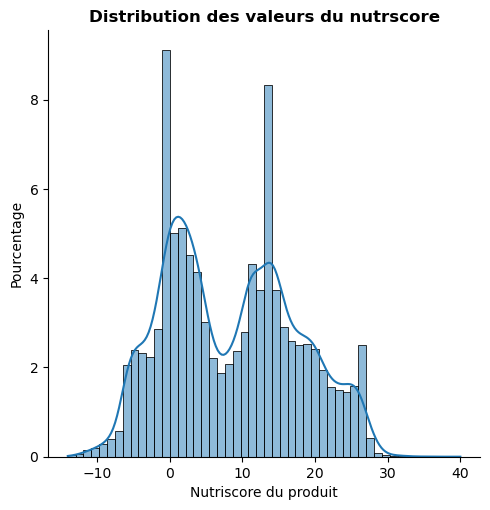

In [74]:
plt.figure(figsize=(10, 6))
sns.displot(data=df_features, x="nutrition-score-fr_100g", bins=50, stat="percent", kde=True)
plt.title("Distribution des valeurs du nutrscore", fontweight="bold")
plt.xlabel("Nutriscore du produit")
plt.ylabel("Pourcentage")

On constate des valeurs inférieures à -10 sur l'histogramme.

In [76]:
df_features["nutrition-score-fr_100g"].describe()

count    48444.000000
mean         8.496037
std          9.051949
min        -14.000000
25%          1.000000
50%          8.000000
75%         15.000000
max         40.000000
Name: nutrition-score-fr_100g, dtype: float64

La valeur minimum est bien de -14, analysons cela :

In [78]:
df_features.loc[df_features["nutrition-score-fr_100g"] < -10, :]

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
111070,148.0,0.50,0.10,4.00,3.0,4.1,2.1,0.010008,0.003940,-11.0
111441,331.0,0.90,0.20,9.00,2.6,5.5,5.9,0.010000,0.003937,-13.0
177548,137.0,0.12,0.12,3.72,1.0,4.4,2.0,0.040000,0.015700,-11.0
178902,284.0,1.90,0.30,9.50,2.5,5.1,3.6,0.010000,0.003937,-12.0
179245,175.0,0.40,0.08,8.30,2.0,4.1,3.6,0.025400,0.010000,-12.0
...,...,...,...,...,...,...,...,...,...,...
311266,150.0,0.20,0.00,2.70,1.3,5.4,3.3,0.199898,0.078700,-12.0
311270,161.0,0.50,0.50,4.70,3.4,3.8,1.9,0.050800,0.020000,-11.0
311449,411.0,0.40,0.10,14.40,4.7,5.5,6.3,0.177800,0.070000,-11.0
311450,89.0,0.00,0.00,0.30,0.0,4.2,3.0,0.076200,0.030000,-11.0


Nous pouvons constater que uniquement 120 valeurs sont concernées. Calculons le pourcentage :

In [80]:
df_features.loc[df_features["nutrition-score-fr_100g"] < -10, :].shape[0] * 100 / df_features.shape[0]

0.17146776406035666

Le pourcentage est inférieure à 1%, nous choisissons donc de fixer les valeurs à -10.

In [82]:
df_features.loc[df_features["nutrition-score-fr_100g"] < -10, "nutrition-score-fr_100g"] = -10

## Informations nutritionelles hors énergie : features _100g

Tout d'abord, toutes ces informations devraient être comprises entre 0 et 100, étant donné que ce sont les composantes des produits. Hors nous pouvons constater certains outliers supérieurs à 100.

Text(0.5, 0, 'Valeurs prises par la feature')

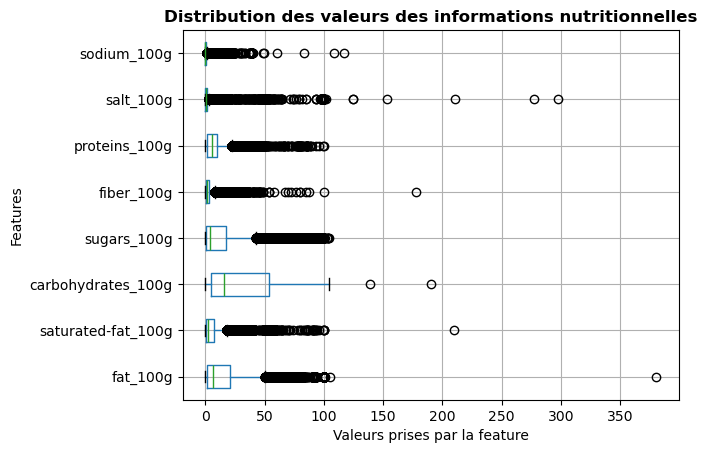

In [85]:
df_features.boxplot(column = ["fat_100g", 
    "saturated-fat_100g",
    "carbohydrates_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g",
    "sodium_100g"], vert=False)
plt.title("Distribution des valeurs des informations nutritionnelles", fontweight="bold")
plt.ylabel("Features")
plt.xlabel("Valeurs prises par la feature")

### Pourcentage de valeurs supérieures à 100

Pour chacune des informations nutritionnelles, déterminons le pourcentage de valeurs supérieures à 100, afin d'évaluer si leur suppression serait problématique pour la distribution des valeurs.

In [88]:
for feature in df_features.columns.to_list() :
    if (df_features.dtypes[feature] != "O") & (feature != "energy_100g") :
        print(f"{feature} : {df_features.loc[df_features[feature]>100, :].shape[0] * 100 / df_features.shape[0]}")

fat_100g : 0.0042866941015089165
saturated-fat_100g : 0.0014288980338363053
carbohydrates_100g : 0.010002286236854138
sugars_100g : 0.007144490169181527
fiber_100g : 0.0014288980338363053
proteins_100g : 0.0
salt_100g : 0.010002286236854138
sodium_100g : 0.0028577960676726107
nutrition-score-fr_100g : 0.0


Nous pouvons constater au maximum 1% de valeurs, remplacons donc ces valeurs par NaN

In [90]:
for feature in df_features.columns.to_list() :
    if (df_features.dtypes[feature] != "O") & (feature != "energy_100g") :
        df_features.loc[df_features[feature]>100, feature] = np.nan

### Cas particuliers

#### Sodium et sel

Le sodium est naturellement présent dans le sel, à hauteur de 40%. Aussi, vérifions cela dans notre échantillon :

<Axes: xlabel='salt_100g', ylabel='sodium_100g'>

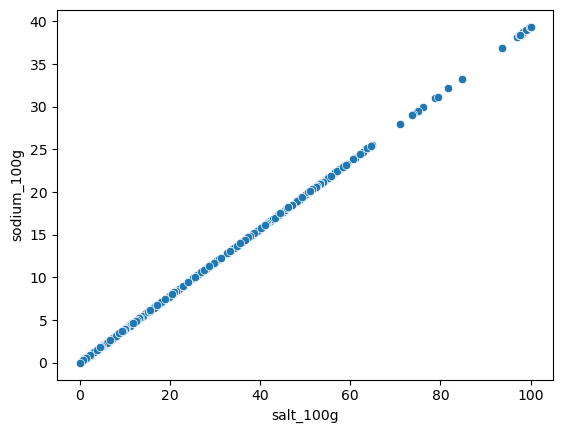

In [94]:
sns.scatterplot(data=df_features, x="salt_100g", y="sodium_100g")

Cela semble se vérifier parfaitement.

#### Matières grasses et acides gras saturés

Les acides gras saturés composant la matière grasse leur valeur devrait toujours être inférieure à celle des matières grasses. Vérifions cela.

In [98]:
df_features.loc[df_features["fat_100g"] < df_features["saturated-fat_100g"], :]

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
35809,2151.0,26.9000,27.000,61.70,23.0000,2.00,5.00,1.00000,0.393701,23.0
88033,NaN,14.5000,20.000,72.70,NaN,5.45,9.09,0.32300,0.127000,NaN
99205,540.0,0.0000,0.100,26.32,23.0000,0.00,2.20,11.80000,4.645669,16.0
99206,540.0,0.0000,0.100,26.32,23.0000,0.00,2.20,11.80000,4.645669,16.0
105707,510.0,0.0000,0.100,28.00,18.0000,0.00,1.80,7.31520,2.880000,14.0
175616,196.0,0.0001,0.210,5.67,2.9000,0.90,1.97,0.00000,0.000000,-2.0
176935,2570.0,54.8000,73.800,7.00,5.5000,9.40,20.50,0.07000,0.027559,13.0
177333,1990.0,23.0000,23.100,60.00,48.0000,NaN,4.50,0.20000,0.078740,25.0
184903,1000.0,0.0000,0.500,98.00,0.5000,0.50,0.00,0.00000,0.000000,2.0
185447,127.0,0.4000,1.000,4.00,2.3000,1.90,1.70,0.07620,0.030000,-8.0


In [99]:
df_features.loc[df_features["fat_100g"] < df_features["saturated-fat_100g"], :].shape[0] * 100 / df_features.shape[0]

0.1071673525377229

Ces valeurs en représentent que 0,1% de l'échantillon. Echangeons tout simplement les deux variables.

In [101]:
mg = df_features.loc[df_features["fat_100g"] < df_features["saturated-fat_100g"], "fat_100g"]
ags = df_features.loc[df_features["fat_100g"] < df_features["saturated-fat_100g"], "saturated-fat_100g"]

df_features.loc[df_features["fat_100g"] < df_features["saturated-fat_100g"], "saturated-fat_100g"] = mg
df_features.loc[df_features["fat_100g"] < df_features["saturated-fat_100g"], "fat_100g"] = ags

## Energie

L'énergie pour 100g n'est pas une composante à part entière du produit mais une conséquence des ingrédients, aussi sa valeur n'est pas limitée entre 0 et 100 (contrairement aux autres informations nutritionnelles). Aussi nous lui appliquerons un traitement différent.

Text(0.5, 0, "Valeurs prises par l'énergie")

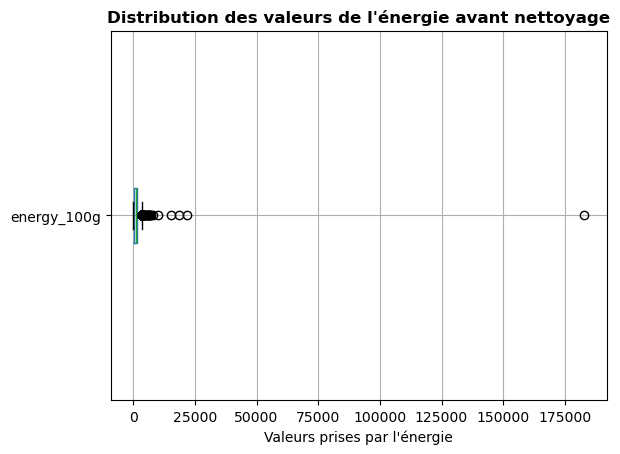

In [104]:
df_features.boxplot(column = ["energy_100g"], vert=False)
plt.title("Distribution des valeurs de l'énergie avant nettoyage", fontweight="bold")
plt.xlabel("Valeurs prises par l'énergie")

Pour traiter les outliers ici, nous utiliserons la méthode de l'écart-type.

Ainsi, nous supprimerons toutes les valeurs étant au dessus de la moyenne + 3 écart-type.

In [106]:
moyenne = df_features["energy_100g"].mean()
ecart_type = df_features["energy_100g"].std()
tolerance = 3

df_features.loc[df_features["energy_100g"] > moyenne + tolerance * ecart_type, "energy_100g"] = np.nan

Affichons la distribution après nettoyage.

Text(0.5, 0, "Valeurs prises par l'énergie")

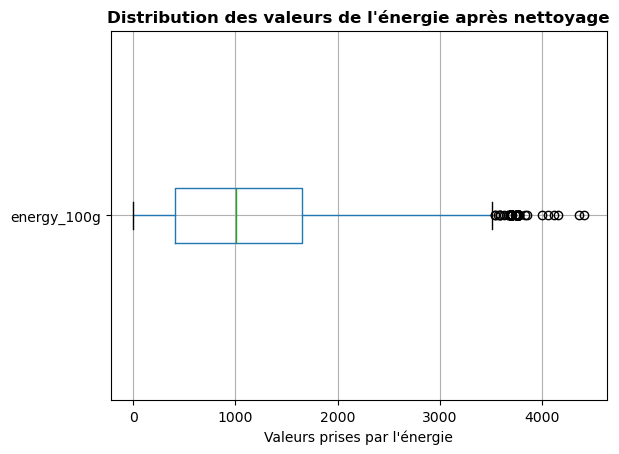

In [108]:
df_features.boxplot(column = ["energy_100g"], vert=False)
plt.title("Distribution des valeurs de l'énergie après nettoyage", fontweight="bold")
plt.xlabel("Valeurs prises par l'énergie")

# Traitement des valeurs manquantes des features

Afin de toujours conserver le même nombre de ligne dans les dataframes cible et features, nous allons les concaténer pour cette partie de l'étude.

In [111]:
df_cible_features = pd.concat([df_cible, df_features], axis=1)

## Analyse des valeurs de la cible

Nous avons déjà supprimé les valeurs manquantes correspondant à la cible, cependant, il serait intéressant de vérifier la cohérence des valeurs prises par la cible (doublons, valeurs abberantes ?)

In [114]:
df_cible_features["pnns_groups_1"].unique()

array(['unknown', 'Fruits and vegetables', 'Sugary snacks',
       'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs',
       'Beverages', 'Fat and sauces', 'fruits-and-vegetables',
       'Milk and dairy products', 'Salty snacks', 'sugary-snacks',
       'cereals-and-potatoes', 'salty-snacks'], dtype=object)

On peut constater que certaines valeurs se répetent :
- "Fruits and vegetables" et "fruits-and-vegetables"
- "Salty snacks" et "salty-snacks"
- "Cereals and potatoes" et "cereals-and-potatoes"
- "Sugary snacks" et "sugary-snacks"

Nous allons, par conséquent, commencer par harmoniser les valeurs.
De plus, une valeur "unknown" apparait, nous allons la remplacer par NaN étant donné que nous ne pouvons pas, pour l'instant, déterminer la bonne valeur.

In [116]:
df_cible_features.loc[products["pnns_groups_1"] == "fruits-and-vegetables", "pnns_groups_1"] = "Fruits and vegetables"
df_cible_features.loc[products["pnns_groups_1"] == "salty-snacks", "pnns_groups_1"] = "Salty snacks"
df_cible_features.loc[products["pnns_groups_1"] == "cereals-and-potatoes", "pnns_groups_1"] = "Cereals and potatoes"
df_cible_features.loc[products["pnns_groups_1"] == "sugary-snacks", "pnns_groups_1"] = "Sugary snacks"
df_cible_features.loc[products["pnns_groups_1"] == "unknown", "pnns_groups_1"] = np.nan

In [117]:
df_cible_features["pnns_groups_1"].unique()

array([nan, 'Fruits and vegetables', 'Sugary snacks',
       'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs',
       'Beverages', 'Fat and sauces', 'Milk and dairy products',
       'Salty snacks'], dtype=object)

Mettons à jour notre dataframe, avec uniquement les lignes pour lesquelles notre variable cible est renseignée.

In [119]:
df_cible_features = df_cible_features.loc[df_cible_features["pnns_groups_1"].notnull(), :]

## Comptons les valeurs manquantes par ligne

Affichons le nombre lignes par nombre de valeurs manquantes par ligne 

<Axes: ylabel='Count'>

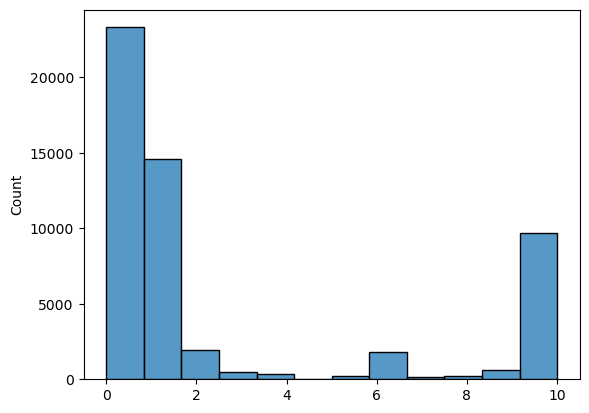

In [122]:
sns.histplot(df_cible_features.isnull().sum(axis=1), bins=12)

Supprimons de notre dataframe, les lignes ne possédant pas suffisamment de valeurs.

Nous considérerons ici qu'il est nécessaire d'avoir moins de 2 colonnes vides pour que le reste de l'analyse soit pertinente.

In [124]:
seuil = 2

df_cible_features = df_cible_features[df_cible_features.isnull().sum(axis=1) <= seuil]

<Axes: ylabel='Count'>

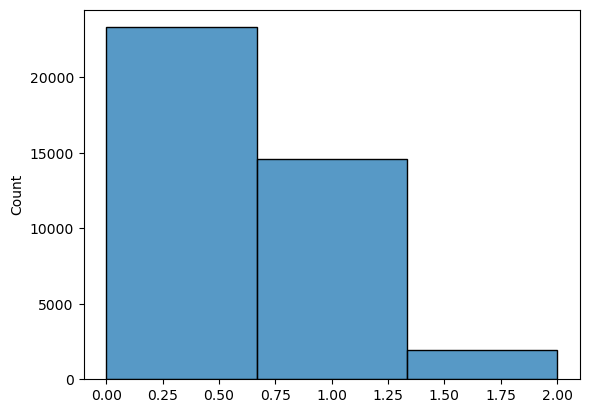

In [125]:
sns.histplot(df_cible_features.isnull().sum(axis=1), bins=3)

## Calculons la proportion de valeur manquante pour chaque variable

In [127]:
df_cible_features.isnull().sum() * 100 / df_cible_features.shape[0]

pnns_groups_1               0.000000
energy_100g                 0.060255
fat_100g                    4.270543
saturated-fat_100g          0.251061
carbohydrates_100g          4.348372
sugars_100g                 0.208380
fiber_100g                 35.921769
proteins_100g               0.123020
salt_100g                   0.007532
sodium_100g                 0.005021
nutrition-score-fr_100g     1.119731
dtype: float64

## Correlation entre les variables

Traçons une matrice de correlation pour étudier les relations entre nos variables.

Nous utiliserons cela pour déterminer les variables sur lesquelles nous pourrons effectuer une régression linéaire et d'autres méthodes pour les autres.

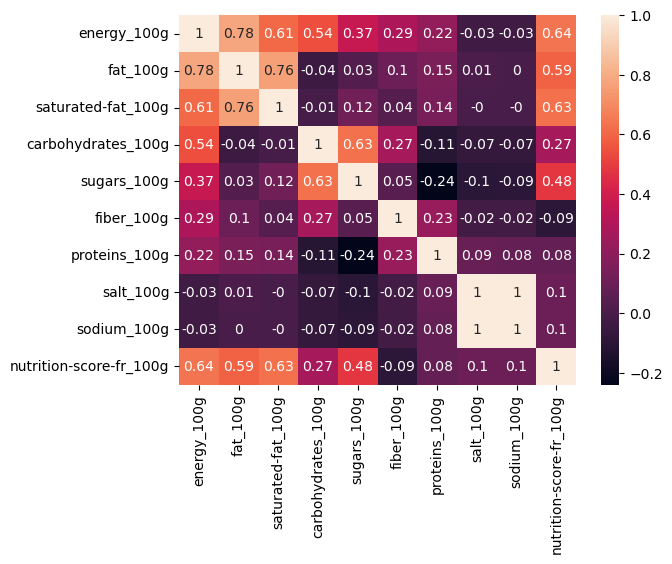

In [130]:
correlation_matrix = df_features.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True);

Nous pouvons constater plusieurs fortes correlations, et donc nous pouvons envisager d'effectuer les régressions linéaires suivantes :
- energy_100g ~ fat_100g + saturated-fat_100g + carbohydrates_100g
- fat_100g ~ energy_100g + saturated-fat_100g
- saturated-fat_100g ~ fat_100g + energy_100g
- carbohydrates_100g ~ sugars_100g + energy_100g
- sugars_100g ~ carbohydrates_100g
- nutrition-score-fr_100g ~ saturated-fat_100g + energy_100g + fat_100g + sugars_100g


## Imputation statiques

Etant donné les correlation établies plus tôt, les proportions de valeurs manquantes et le fait que nous avons besoin d'avoir toutes les valeurs disponibles pour utiliser les modèles de regression linéaire, nous allons effectuer des imputations statiques sur les variables suivantes :
- energy_100g
- sugars_100g
- saturated-fat_100g 


### energy_100g

<Axes: >

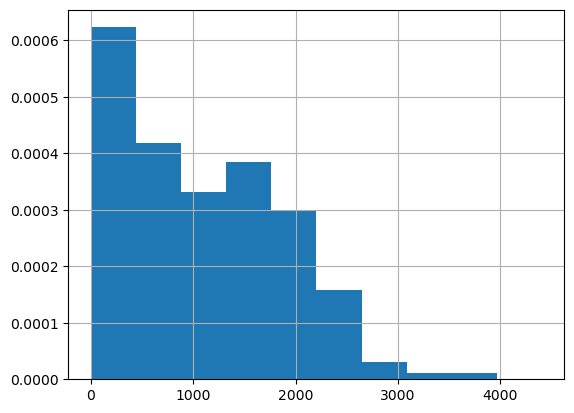

In [135]:
df_cible_features["energy_100g"].hist(density=True)

La répartition des valeurs est plutôt équilibrée pour cette variable, aussi nous remplacerons les valeurs manquantes par la valeur moyenne qui sera plus représentative.

In [137]:
df_cible_features.loc[df_cible_features["energy_100g"].isnull(), 
    "energy_100g"] = df_cible_features["energy_100g"].mean()

### sugars_100g

<Axes: >

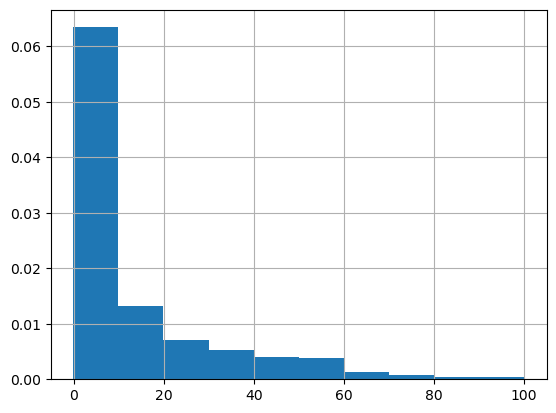

In [139]:
df_cible_features["sugars_100g"].hist(density=True)

La répartition des valeurs est très déséquilibrée pour cette variable, aussi nous remplacerons les valeurs manquantes par la valeur médiane qui sera plus représentative.

In [141]:
df_cible_features.loc[df_cible_features["sugars_100g"].isnull(), 
    "sugars_100g"] = df_cible_features["sugars_100g"].median()

### saturated-fat_100g

<Axes: >

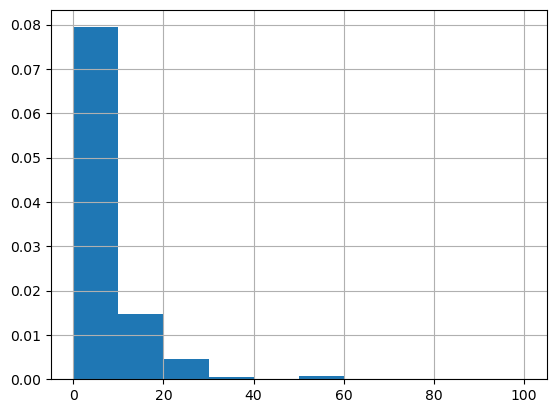

In [143]:
df_cible_features["saturated-fat_100g"].hist(density=True)

La répartition des valeurs est très déséquilibrée pour cette variable, aussi nous remplacerons les valeurs manquantes par la valeur médiane qui sera plus représentative.

In [145]:
df_cible_features.loc[df_cible_features["saturated-fat_100g"].isnull(), 
    "saturated-fat_100g"] = df_cible_features["saturated-fat_100g"].median()

## Régression linéaire

Pour l'entrainement de nos modèles de regression linéaire, nous allons avoir besoin d'un dataframe sans valeurs manquantes.

Créons donc ce dataframe.

In [148]:
df_reg = df_cible_features.dropna()
df_reg = df_reg.drop("pnns_groups_1", axis=1)

### fat_100g

fat_100g ~ energy_100g + saturated-fat_100g

Analysons les diagrammes de dispersion

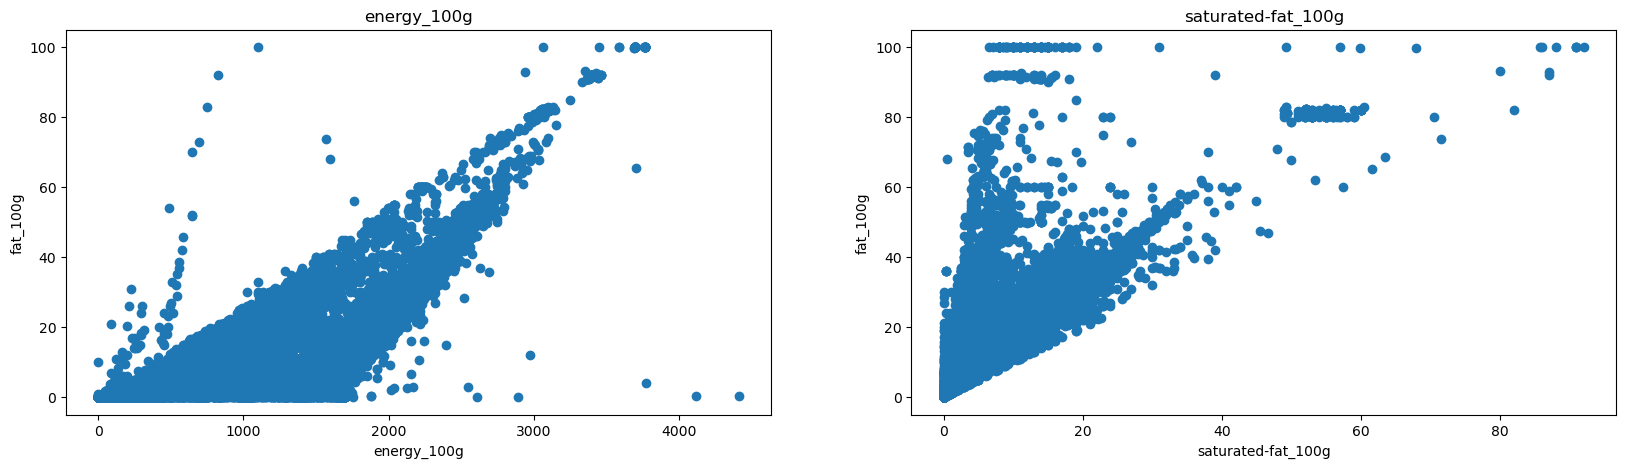

In [152]:
plt.figure(figsize=(20, 5))

features = ["energy_100g", "saturated-fat_100g"]
cible = df_reg["fat_100g"]

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = df_reg[col]
    y = cible
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('fat_100g')

Créons nos variables pour la régression linéaire :

In [530]:
X = pd.DataFrame(np.c_[df_reg["energy_100g"], df_reg["saturated-fat_100g"]]
    , columns = ["energy_100g", "saturated-fat_100g"])

Y = df_reg["fat_100g"]

Séparons nos données en données d'entrainement et données de test

In [532]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=8)

Normalisons nos données

In [534]:
# On crée l'objet minmaxscaler
scaler = MinMaxScaler()

# On adapte le scaler avec nos données d'entrainement
scaler.fit(X_train)

# On met nos données à l'échelle
data_X_train = scaler.transform(X_train)
X_train = pd.DataFrame(data_X_train, columns=X.columns)
data_X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data_X_test, columns=X.columns)

Création du modèle

In [536]:
modele_fat = LinearRegression()

On entraine le modèle

In [538]:
modele_fat.fit(X_train, Y_train)

LinearRegression()

In [540]:
# évaluation du modèle pour l'ensemble d'entraînement
y_train_predict = modele_fat.predict(X_train)
# racine carrée de l'erreur quadratique moyenne du modèle
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
# score du modèle
score = modele_fat.score(X_train, Y_train)
print("La performance du Modèle pour le set de Training")
print("------------------------------------------------")
print("l'erreur RMSE esst {}".format(rmse))
print('le score est {}'.format(score))
print("\n")


# évaluation du modèle pour le set de test
y_test_predict = modele_fat.predict(X_test)
# racine carrée de l'erreur quadratique moyenne du modèle
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
# score du modèle
score = modele_fat.score(X_test, Y_test)
print("La performance du Modèle pour le set de Test")
print("--------------------------------------------")
print("l'erreur RMSE est {}".format(rmse))
print('le score est {}'.format(score))

La performance du Modèle pour le set de Training
------------------------------------------------
l'erreur RMSE esst 7.882560367435565
le score est 0.7316339837757907


La performance du Modèle pour le set de Test
--------------------------------------------
l'erreur RMSE est 7.613507965739221
le score est 0.747651662704895


Les scores peuvent être optimisés. Nous allons essayer une régression polynomiale

In [543]:
X = pd.DataFrame(np.c_[df_reg["energy_100g"], df_reg["saturated-fat_100g"]]
    , columns = ["energy_100g", "saturated-fat_100g"])

X["energy_100g2"] = X["energy_100g"] ** 2
X["saturated-fat_100g2"] = X["saturated-fat_100g"] ** 2

Y = df_reg["fat_100g"]

Séparons nos données en données d'entrainement et données de test

In [545]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=8)

Normalisons nos données

In [547]:
# On crée l'objet minmaxscaler
scaler = MinMaxScaler()

# On adapte le scaler avec nos données d'entrainement
scaler.fit(X_train)

# On met nos données à l'échelle
data_X_train = scaler.transform(X_train)
X_train = pd.DataFrame(data_X_train, columns=X.columns)
data_X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data_X_test, columns=X.columns)

Création du modèle

In [549]:
modele_fat = LinearRegression()

On entraine le modèle

In [551]:
modele_fat.fit(X_train, Y_train)

LinearRegression()

In [553]:
# évaluation du modèle pour l'ensemble d'entraînement
y_train_predict = modele_fat.predict(X_train)
# racine carrée de l'erreur quadratique moyenne du modèle
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
# score du modèle
score = modele_fat.score(X_train, Y_train)
print("La performance du Modèle pour le set de Training")
print("------------------------------------------------")
print("l'erreur RMSE esst {}".format(rmse))
print('le score est {}'.format(score))
print("\n")


# évaluation du modèle pour le set de test
y_test_predict = modele_fat.predict(X_test)
# racine carrée de l'erreur quadratique moyenne du modèle
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
# score du modèle
score = modele_fat.score(X_test, Y_test)
print("La performance du Modèle pour le set de Test")
print("--------------------------------------------")
print("l'erreur RMSE est {}".format(rmse))
print('le score est {}'.format(score))

La performance du Modèle pour le set de Training
------------------------------------------------
l'erreur RMSE esst 6.125721209324226
le score est 0.8379282343128208


La performance du Modèle pour le set de Test
--------------------------------------------
l'erreur RMSE est 5.8812457105513465
le score est 0.8494192407212228


On constate une nette amélioration. Conservons le modèle en cet état.

### carbohydrates_100g

carbohydrates_100g ~ sugars_100g + energy_100g

Analysons les diagrammes de dispersion

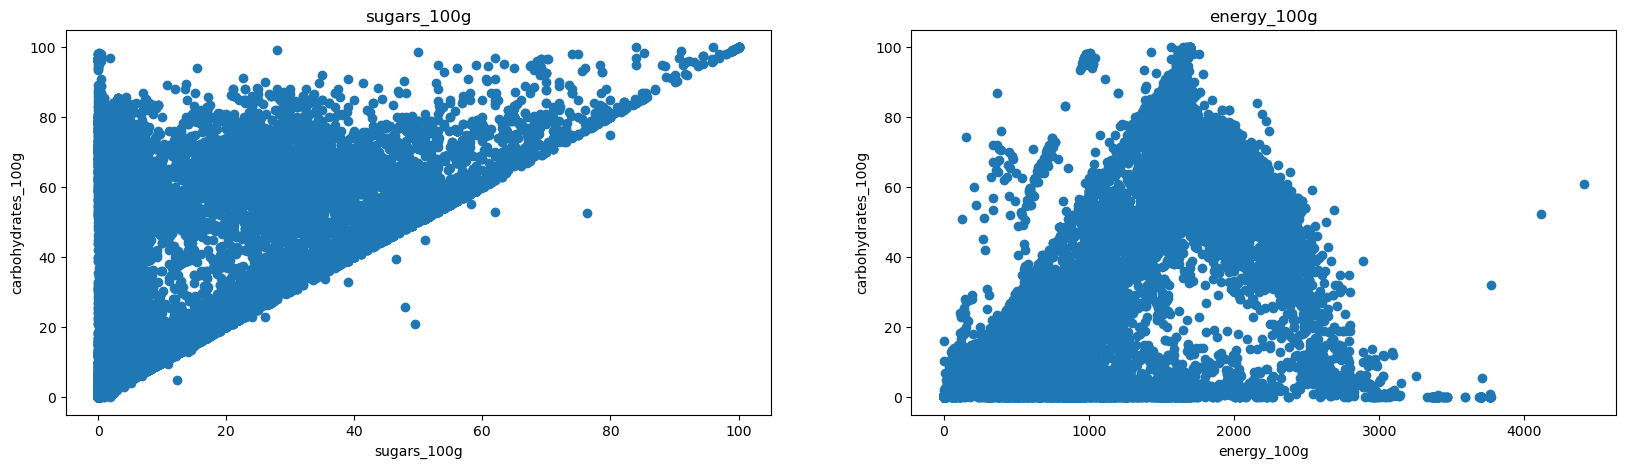

In [167]:
plt.figure(figsize=(20, 5))

features = ["sugars_100g", "energy_100g"]
cible = df_reg["carbohydrates_100g"]

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = df_reg[col]
    y = cible
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('carbohydrates_100g')

Créons nos variables pour la régression linéaire :

In [432]:
X = pd.DataFrame(np.c_[df_reg["sugars_100g"], df_reg["energy_100g"]]
    , columns = ["sugars_100g", "energy_100g"])

Y = df_reg["carbohydrates_100g"]

Séparons nos données en données d'entrainement et données de test

In [434]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=8)

Normalisons nos données

In [436]:
# On crée l'objet minmaxscaler
scaler = MinMaxScaler()

# On adapte le scaler avec nos données d'entrainement
scaler.fit(X_train)

# On met nos données à l'échelle
data_X_train = scaler.transform(X_train)
X_train = pd.DataFrame(data_X_train, columns=X.columns)
data_X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data_X_test, columns=X.columns)

Création du modèle

In [438]:
modele_carbohydrates = LinearRegression()

On entraine le modèle

In [440]:
modele_carbohydrates.fit(X_train, Y_train)

LinearRegression()

In [442]:
# évaluation du modèle pour l'ensemble d'entraînement
y_train_predict = modele_carbohydrates.predict(X_train)
# racine carrée de l'erreur quadratique moyenne du modèle
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
# score du modèle
score = modele_carbohydrates.score(X_train, Y_train)
print("La performance du Modèle pour le set de Training")
print("------------------------------------------------")
print("l'erreur RMSE esst {}".format(rmse))
print('le score est {}'.format(score))
print("\n")


# évaluation du modèle pour le set de test
y_test_predict = modele_carbohydrates.predict(X_test)
# racine carrée de l'erreur quadratique moyenne du modèle
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
# score du modèle
score = modele_carbohydrates.score(X_test, Y_test)
print("La performance du Modèle pour le set de Test")
print("--------------------------------------------")
print("l'erreur RMSE est {}".format(rmse))
print('le score est {}'.format(score))

La performance du Modèle pour le set de Training
------------------------------------------------
l'erreur RMSE esst 19.246900657395184
le score est 0.5014714354864872


La performance du Modèle pour le set de Test
--------------------------------------------
l'erreur RMSE est 19.2330547594078
le score est 0.5032286651243982


Le score n'est encore une fois pas très bon, pire encore que le modèle précédent. Essayons de l'améliorer

In [593]:
X = pd.DataFrame(np.c_[df_reg["sugars_100g"], df_reg["energy_100g"], df_reg["fiber_100g"], df_reg["nutrition-score-fr_100g"]]
    , columns = ["sugars_100g", "energy_100g", "fiber_100g", "nutrition-score-fr_100g"])

X["sugars_100g2"] = X["sugars_100g"] ** 2
X["energy_100g2"] = X["energy_100g"] ** 2

Y = df_reg["carbohydrates_100g"]

Séparons nos données en données d'entrainement et données de test

In [595]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=8)

Normalisons nos données

In [597]:
# On crée l'objet minmaxscaler
scaler = MinMaxScaler()

# On adapte le scaler avec nos données d'entrainement
scaler.fit(X_train)

# On met nos données à l'échelle
data_X_train = scaler.transform(X_train)
X_train = pd.DataFrame(data_X_train, columns=X.columns)
data_X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data_X_test, columns=X.columns)

Création du modèle

In [599]:
modele_carbohydrates = LinearRegression()

On entraine le modèle

In [601]:
modele_carbohydrates.fit(X_train, Y_train)

LinearRegression()

In [603]:
# évaluation du modèle pour l'ensemble d'entraînement
y_train_predict = modele_carbohydrates.predict(X_train)
# racine carrée de l'erreur quadratique moyenne du modèle
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
# score du modèle
score = modele_carbohydrates.score(X_train, Y_train)
print("La performance du Modèle pour le set de Training")
print("------------------------------------------------")
print("l'erreur RMSE esst {}".format(rmse))
print('le score est {}'.format(score))
print("\n")


# évaluation du modèle pour le set de test
y_test_predict = modele_carbohydrates.predict(X_test)
# racine carrée de l'erreur quadratique moyenne du modèle
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
# score du modèle
score = modele_carbohydrates.score(X_test, Y_test)
print("La performance du Modèle pour le set de Test")
print("--------------------------------------------")
print("l'erreur RMSE est {}".format(rmse))
print('le score est {}'.format(score))

La performance du Modèle pour le set de Training
------------------------------------------------
l'erreur RMSE esst 14.439689935759533
le score est 0.7194022570297522


La performance du Modèle pour le set de Test
--------------------------------------------
l'erreur RMSE est 14.487425242756437
le score est 0.7181341848655947


Nous sommes passés d'un score de 0.5 environ à un score de 0.72 environ et diminuer la RMSE de quasiment 5 points, ce qui est plutôt satisfaisant

### nutrition-score-fr_100g

nutrition-score-fr_100g ~ saturated-fat_100g + energy_100g + fat_100g + sugars_100g

Analysons les diagrammes de dispersion

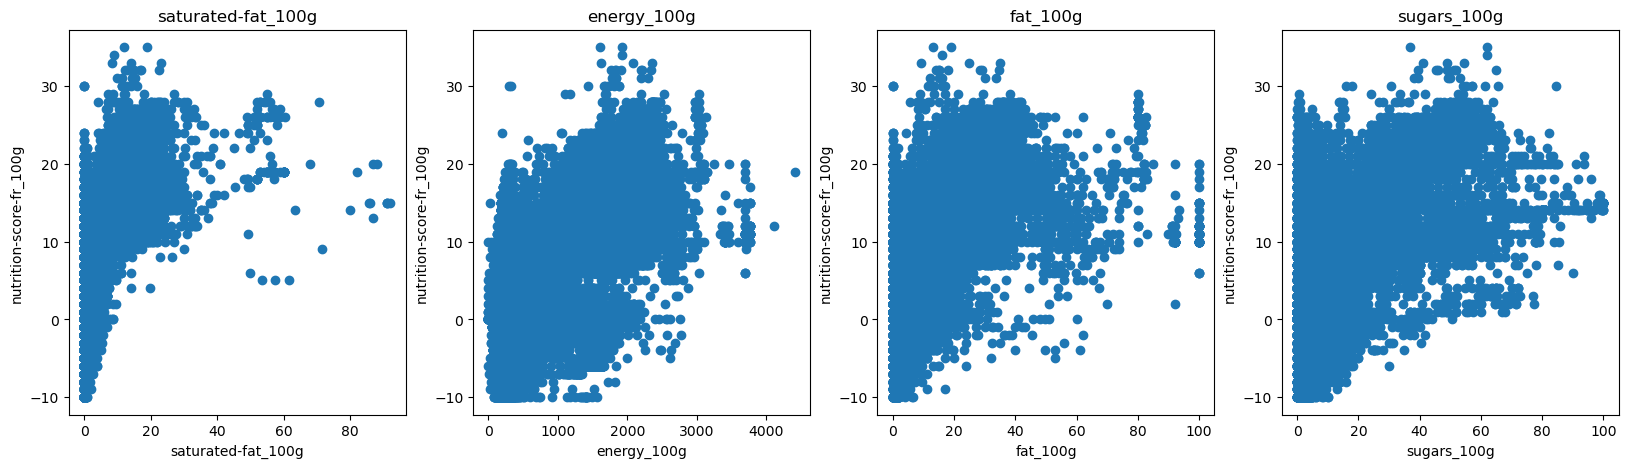

In [608]:
plt.figure(figsize=(20, 5))

features = ["saturated-fat_100g", "energy_100g", "fat_100g", "sugars_100g"]
cible = df_reg["nutrition-score-fr_100g"]

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = df_reg[col]
    y = cible
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('nutrition-score-fr_100g')

Créons nos variables pour la régression linéaire :

In [612]:
X = pd.DataFrame(np.c_[df_reg["saturated-fat_100g"], df_reg["energy_100g"], df_reg["fat_100g"], df_reg["sugars_100g"]]
    , columns = ["saturated-fat_100g", "energy_100g", "fat_100g", "sugars_100g"])

Y = df_reg["nutrition-score-fr_100g"]

Séparons nos données en données d'entrainement et données de test

In [614]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=8)

Normalisons nos données

In [616]:
# On crée l'objet minmaxscaler
scaler = MinMaxScaler()

# On adapte le scaler avec nos données d'entrainement
scaler.fit(X_train)

# On met nos données à l'échelle
data_X_train = scaler.transform(X_train)
X_train = pd.DataFrame(data_X_train, columns=X.columns)
data_X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data_X_test, columns=X.columns)

Création du modèle

In [618]:
modele_nutriscore = LinearRegression()

On entraine le modèle

In [620]:
modele_nutriscore.fit(X_train, Y_train)

LinearRegression()

In [622]:
# évaluation du modèle pour l'ensemble d'entraînement
y_train_predict = modele_nutriscore.predict(X_train)
# racine carrée de l'erreur quadratique moyenne du modèle
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
# score du modèle
score = modele_nutriscore.score(X_train, Y_train)
print("La performance du Modèle pour le set de Training")
print("------------------------------------------------")
print("l'erreur RMSE esst {}".format(rmse))
print('le score est {}'.format(score))
print("\n")


# évaluation du modèle pour le set de test
y_test_predict = modele_nutriscore.predict(X_test)
# racine carrée de l'erreur quadratique moyenne du modèle
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
# score du modèle
score = modele_nutriscore.score(X_test, Y_test)
print("La performance du Modèle pour le set de Test")
print("--------------------------------------------")
print("l'erreur RMSE est {}".format(rmse))
print('le score est {}'.format(score))

La performance du Modèle pour le set de Training
------------------------------------------------
l'erreur RMSE esst 5.523372021946824
le score est 0.6196041655604966


La performance du Modèle pour le set de Test
--------------------------------------------
l'erreur RMSE est 5.5151142999134946
le score est 0.625522555671628


Les scores peuvent être optimisés. Nous allons essayer une régression polynomiale

In [624]:
X = pd.DataFrame(np.c_[df_reg["saturated-fat_100g"], df_reg["energy_100g"], df_reg["fat_100g"], df_reg["sugars_100g"]]
    , columns = ["saturated-fat_100g", "energy_100g", "fat_100g", "sugars_100g"])

X["saturated-fat_100g2"] = X["saturated-fat_100g"] ** 2
X["energy_100g2"] = X["energy_100g"] ** 2
X["fat_100g2"] = X["fat_100g"] ** 2
X["sugars_100g2"] = X["sugars_100g"] ** 2

Y = df_reg["nutrition-score-fr_100g"]

Séparons nos données en données d'entrainement et données de test

In [626]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=8)

Normalisons nos données

In [628]:
# On crée l'objet minmaxscaler
scaler = MinMaxScaler()

# On adapte le scaler avec nos données d'entrainement
scaler.fit(X_train)

# On met nos données à l'échelle
data_X_train = scaler.transform(X_train)
X_train = pd.DataFrame(data_X_train, columns=X.columns)
data_X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data_X_test, columns=X.columns)

Création du modèle

In [630]:
modele_nutriscore = LinearRegression()

On entraine le modèle

In [632]:
modele_nutriscore.fit(X_train, Y_train)

LinearRegression()

In [634]:
# évaluation du modèle pour l'ensemble d'entraînement
y_train_predict = modele_nutriscore.predict(X_train)
# racine carrée de l'erreur quadratique moyenne du modèle
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
# score du modèle
score = modele_nutriscore.score(X_train, Y_train)
print("La performance du Modèle pour le set de Training")
print("------------------------------------------------")
print("l'erreur RMSE esst {}".format(rmse))
print('le score est {}'.format(score))
print("\n")


# évaluation du modèle pour le set de test
y_test_predict = modele_nutriscore.predict(X_test)
# racine carrée de l'erreur quadratique moyenne du modèle
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
# score du modèle
score = modele_nutriscore.score(X_test, Y_test)
print("La performance du Modèle pour le set de Test")
print("--------------------------------------------")
print("l'erreur RMSE est {}".format(rmse))
print('le score est {}'.format(score))

La performance du Modèle pour le set de Training
------------------------------------------------
l'erreur RMSE esst 4.942110817209448
le score est 0.6954545469130982


La performance du Modèle pour le set de Test
--------------------------------------------
l'erreur RMSE est 4.909276756663682
le score est 0.7032766929076477


Encore une fois on constate un augmentation du score, bien que moins significative.

### Utilisons nos modèles pour remplir les valeurs manquantes dans le dataframe de travail

#### fat_100g

fat_100g ~ energy_100g + saturated-fat_100g

Tout d'abord, on crée notre dataframe de features

In [198]:
X_fat = pd.DataFrame(np.c_[df_cible_features["energy_100g"], df_cible_features["saturated-fat_100g"]],
    columns=["energy_100g", "saturated-fat_100g"])

On normalise les données

In [200]:
# On crée l'objet minmaxscaler
scaler = MinMaxScaler()

# On adapte le scaler avec nos données d'entrainement
scaler.fit(X_fat)

# On met nos données à l'échelle
X_data = scaler.transform(X_fat)
X_fat = pd.DataFrame(X_data, columns=X_fat.columns.to_list())

On effectue notre prédiction

In [202]:
y_predict = modele_fat.predict(X_fat)

Etant donné que la prédiction retourne un array, on recrée un dataframe

In [204]:
Y_fat = pd.DataFrame(y_predict, columns=["fat_100g"], index=df_cible_features.index)

On récupère à présent, dans le dataframe d'origine, les index des valeurs manquantes

In [206]:
liste_index_a_remplace = df_cible_features.loc[df_cible_features["fat_100g"].isnull(), "fat_100g"].index.to_list()

On se sert des index afin de récupérer les valeurs prédites dans le dataframe issu du modèle

In [208]:
for i in range(len(liste_index_a_remplace)) :
    df_cible_features.loc[liste_index_a_remplace[i], "fat_100g"] = Y_fat.loc[liste_index_a_remplace[i], "fat_100g"]

#### carbohydrates_100g

carbohydrates_100g ~ sugars_100g + energy_100g

Tout d'abord, on crée notre dataframe de features

In [212]:
X_carbohydrates = pd.DataFrame(np.c_[df_cible_features["sugars_100g"], df_cible_features["energy_100g"]],
    columns=["sugars_100g", "energy_100g"])

On normalise les données

In [214]:
# On crée l'objet minmaxscaler
scaler = MinMaxScaler()

# On adapte le scaler avec nos données d'entrainement
scaler.fit(X_carbohydrates)

# On met nos données à l'échelle
X_data = scaler.transform(X_carbohydrates)
X_carbohydrates = pd.DataFrame(X_data, columns=X_carbohydrates.columns)

On effectue notre prédiction

In [216]:
y_predict = modele_carbohydrates.predict(X_carbohydrates)

Etant donné que la prédiction retourne un array, on recrée un dataframe

In [218]:
Y_carbohydrates = pd.DataFrame(y_predict, columns=["carbohydrates_100g"], index=df_cible_features.index)

On récupère à présent, dans le dataframe d'origine, les index des valeurs manquantes

In [220]:
liste_index_a_remplace = df_cible_features.loc[df_cible_features["carbohydrates_100g"].isnull(), "carbohydrates_100g"].index.to_list()

On se sert des index afin de récupérer les valeurs prédites dans le dataframe issu du modèle

In [222]:
for i in range(len(liste_index_a_remplace)) :
    df_cible_features.loc[liste_index_a_remplace[i], "carbohydrates_100g"] = Y_carbohydrates.loc[liste_index_a_remplace[i], "carbohydrates_100g"]

#### nutrition-score-fr_100g

nutrition-score-fr_100g ~ saturated-fat_100g + energy_100g + fat_100g + sugars_100g

Tout d'abord, on crée notre dataframe de features

In [226]:
X_nutriscore = pd.DataFrame(np.c_[df_cible_features["saturated-fat_100g"], 
    df_cible_features["energy_100g"], 
    df_cible_features["fat_100g"], 
    df_cible_features["sugars_100g"]],
    columns=["saturated-fat_100g", 
        "energy_100g", 
        "fat_100g", 
        "sugars_100g"])

On normalise les données

In [228]:
# On crée l'objet minmaxscaler
scaler = MinMaxScaler()

# On adapte le scaler avec nos données d'entrainement
scaler.fit(X_nutriscore)

# On met nos données à l'échelle
X_data = scaler.transform(X_nutriscore)
X_nutriscore = pd.DataFrame(X_data, columns=X_nutriscore.columns)

On effectue notre prédiction

In [230]:
y_predict = modele_nutriscore.predict(X_nutriscore)

Etant donné que la prédiction retourne un array, on recrée un dataframe

In [232]:
Y_nutriscore = pd.DataFrame(y_predict, columns=["nutrition-score-fr_100g"], index=df_cible_features.index)

On récupère à présent, dans le dataframe d'origine, les index des valeurs manquantes

In [234]:
liste_index_a_remplace = df_cible_features.loc[df_cible_features["nutrition-score-fr_100g"].isnull(), 
    "nutrition-score-fr_100g"].index.to_list()

On se sert des index afin de récupérer les valeurs prédites dans le dataframe issu du modèle

In [236]:
for i in range(len(liste_index_a_remplace)) :
    df_cible_features.loc[liste_index_a_remplace[i], 
        "nutrition-score-fr_100g"] = Y_nutriscore.loc[liste_index_a_remplace[i], "nutrition-score-fr_100g"]

## Imputation par les k plus proches voisins

Les variables fiber_100g, proteins_100g, salt_100g affichent de faible taux de correlation avec les autres. Aussi nous n'allons pas les traiter par régression linéaire.

Pour celles-ci, nous allons utiliser une imputation par les k plus proches voisins.

Créons le dataframe que nous allons utiliser par la suite :

In [240]:
df_imputer = df_cible_features.drop("pnns_groups_1", axis=1)

On utilise le modèle KNNImputer, en remplaçant les valeurs NaN, avec 5 voisins.

In [242]:
array_imputed = KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(df_imputer)

Etant donné que la prédiction retourne un array, on recrée un dataframe

In [244]:
df_imputed = pd.DataFrame(array_imputed, columns = df_imputer.columns, index=df_imputer.index)

Affichons les distribution des valeurs avant et après imputation pour nos trois variables :

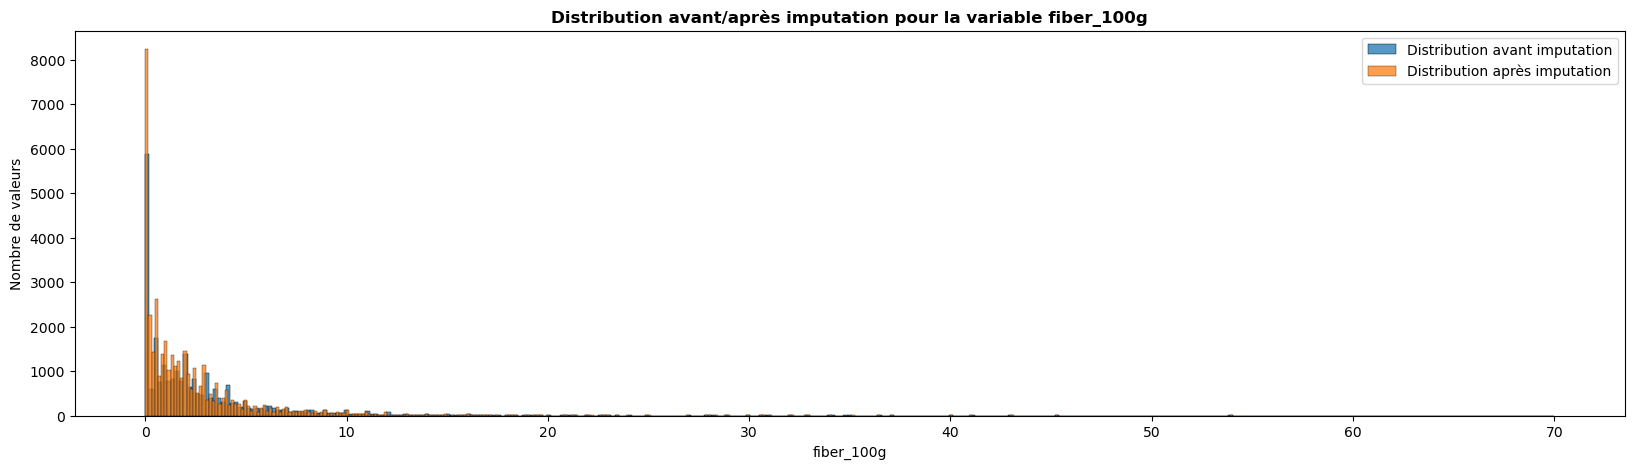

In [246]:
plt.figure(figsize=(20, 5))

# On affiche la distribution avant/après pour "fiber_100g"
sns.histplot(df_cible_features["fiber_100g"], label="Distribution avant imputation")
sns.histplot(df_imputed["fiber_100g"], label="Distribution après imputation")
plt.title("Distribution avant/après imputation pour la variable fiber_100g", fontweight="bold")
plt.ylabel("Nombre de valeurs")
plt.legend()

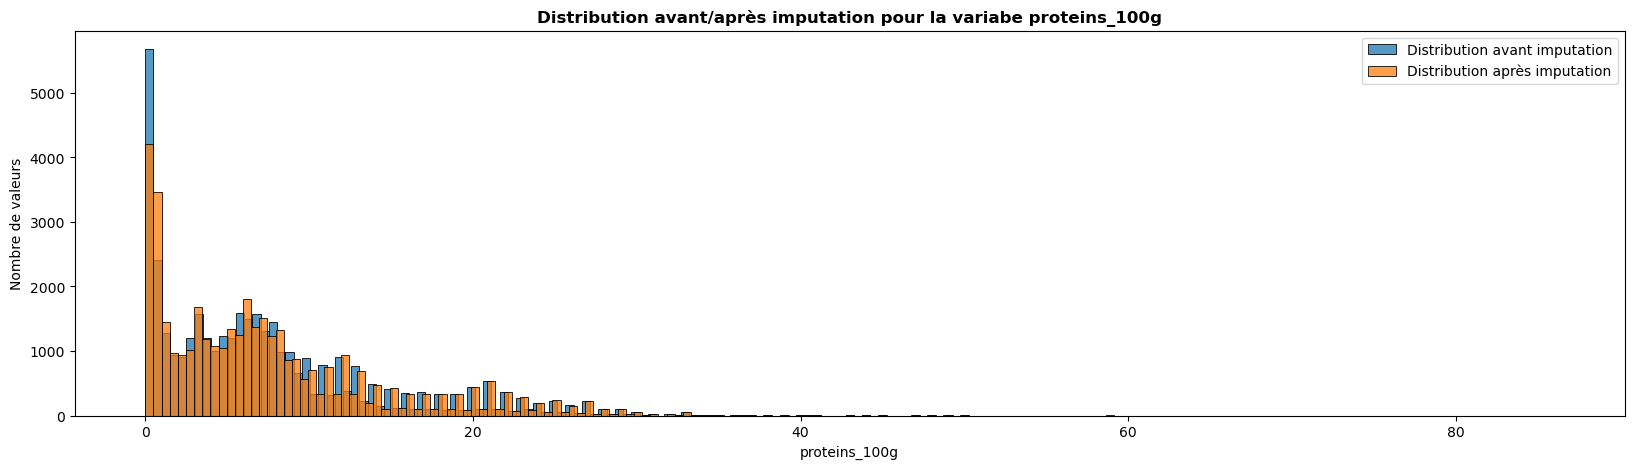

In [247]:
plt.figure(figsize=(20, 5))

# On affiche la distribution avant/après pour "fiber_100g"
sns.histplot(df_cible_features["proteins_100g"], label="Distribution avant imputation")
sns.histplot(df_imputed["proteins_100g"], label="Distribution après imputation")
plt.title("Distribution avant/après imputation pour la variabe proteins_100g", fontweight="bold")
plt.ylabel("Nombre de valeurs")
plt.legend()

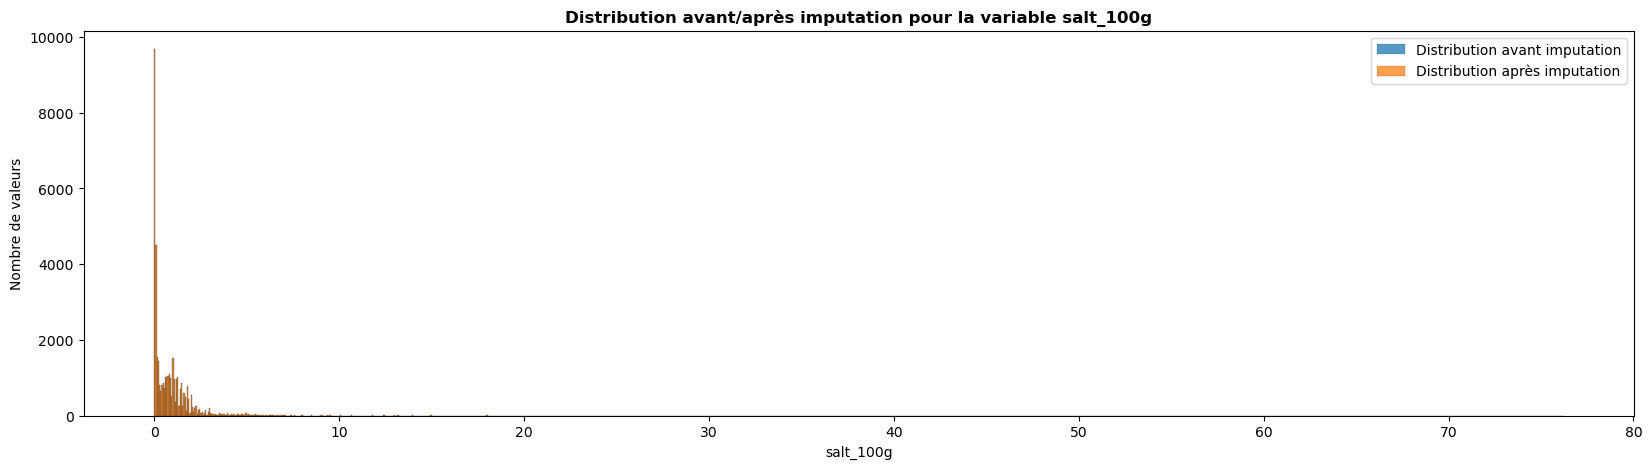

In [248]:
plt.figure(figsize=(20, 5))

# On affiche la distribution avant/après pour "fiber_100g"
sns.histplot(df_cible_features["salt_100g"], label="Distribution avant imputation")
sns.histplot(df_imputed["salt_100g"], label="Distribution après imputation")
plt.title("Distribution avant/après imputation pour la variable salt_100g", fontweight="bold")
plt.ylabel("Nombre de valeurs")
plt.legend()

On constate que les distributions n'ont pas été trop impactées par les imputations, nous conserverons donc les nouvelles valeurs.

In [250]:
df_cible_features["fiber_100g"] = df_imputed["fiber_100g"]
df_cible_features["proteins_100g"] = df_imputed["proteins_100g"]
df_cible_features["salt_100g"] = df_imputed["salt_100g"]

## sodium_100g

Le sodium est naturellement présent dans le sel, à hauteur de 40%. 

Utilisons cette donnée pour remplir les champs manquants.

In [253]:
df_cible_features.loc[df_cible_features["sodium_100g"].isnull(), "sodium_100g"] = df_cible_features["salt_100g"] * 0.4

## Séparons de nouveau les dataframes cibles et features

In [255]:
df_cibles = df_cible_features.loc[:, "pnns_groups_1"]
df_features = df_cible_features.loc[:, features_retenues]

# Analyse des features

## Statistiques univariées

In [258]:
def calcule_statistiques(dataframe, indicateur) :
    print("------------------------------------------------")
    print(f"     Analyse de la feature {indicateur}")
    print("------------------------------------------------")
    plt.figure(figsize = (20, 6))
    grid = plt.GridSpec(1, 3, wspace=0.5, hspace=0.3)
    #plt.title(f"Analyse de la feature {indicateur}")
    # On affiche la distribution empirique de l'indicateur
    plt.subplot(grid[0,0])
    dataframe[indicateur].hist(density=True)
    # Customisation de l'affichage
    plt.title("Distribution empirique", fontweight="bold")
    plt.xlabel(f"{indicateur}")
    plt.ylabel("Répartition")
    plt.grid(axis="x")
    
    # On crée une liste afin de stocker
    liste_statistiques = []
    
    # On ajoute les mesures de tendance centrale
    # Le mode
    liste_statistiques.append(dataframe[indicateur].mode()[0])
    # La moyenne
    liste_statistiques.append(dataframe[indicateur].mean())
    # La médiane
    liste_statistiques.append(dataframe[indicateur].median())
    
    # On ajoute les mesures de dispersion
    # La variance empirique
    liste_statistiques.append(dataframe[indicateur].var(ddof=1))
    # L'écart type
    liste_statistiques.append(dataframe[indicateur].std())

    # Affichons les écarts interquartile
    plt.subplot(grid[0,1])
    dataframe.boxplot(column=[indicateur], vert=True)
    # Customisation de l'affichage    
    plt.title("Ecarts interquartile", fontweight="bold")

    # On ajoute les mesures de forme
    # Le skewness empirique
    liste_statistiques.append(dataframe[indicateur].skew())
    # Le kurtosis empirique
    liste_statistiques.append(dataframe[indicateur].kurtosis())
    
    # Affichons la courbe de Lorenz
    d = dataframe[indicateur].dropna()
    lorenz = np.cumsum(np.sort(d)) / d.sum()
    lorenz = np.append([0], lorenz)
    n = len(d)
    xaxis = np.linspace(0-1/n,1+1/n,n+1)
    
    # Affichage de la courbe
    plt.subplot(grid[0,2])
    plt.plot(xaxis,lorenz,drawstyle='steps-post', label="Courbe de Lorenz")
    # Affichage de la médiane
    plt.plot(xaxis,xaxis,drawstyle='default', label="Médiale")
    # Customisation de l'affichage
    plt.title("Courbe de Lorenz pour la feature", fontweight="bold")
    plt.xlabel(f"{indicateur}")
    plt.legend(loc='upper left')
    plt.grid(color="gray", linestyle="-", linewidth=0.5)

    # Pour des question de présentation, nous convertissons notre liste en dataframe
    df_statistiques = pd.DataFrame(data = liste_statistiques,
        index = [
            "Mode",
            "Moyenne",
            "Médiane",
            "Variance",
            "Ecart type",
            "Skewness",
            "Kurtosis"],
        columns=["Valeurs des statistiques"])
    
    # On affiche toutes nos courbes
    plt.show()
    return df_statistiques

------------------------------------------------
     Analyse de la feature energy_100g
------------------------------------------------


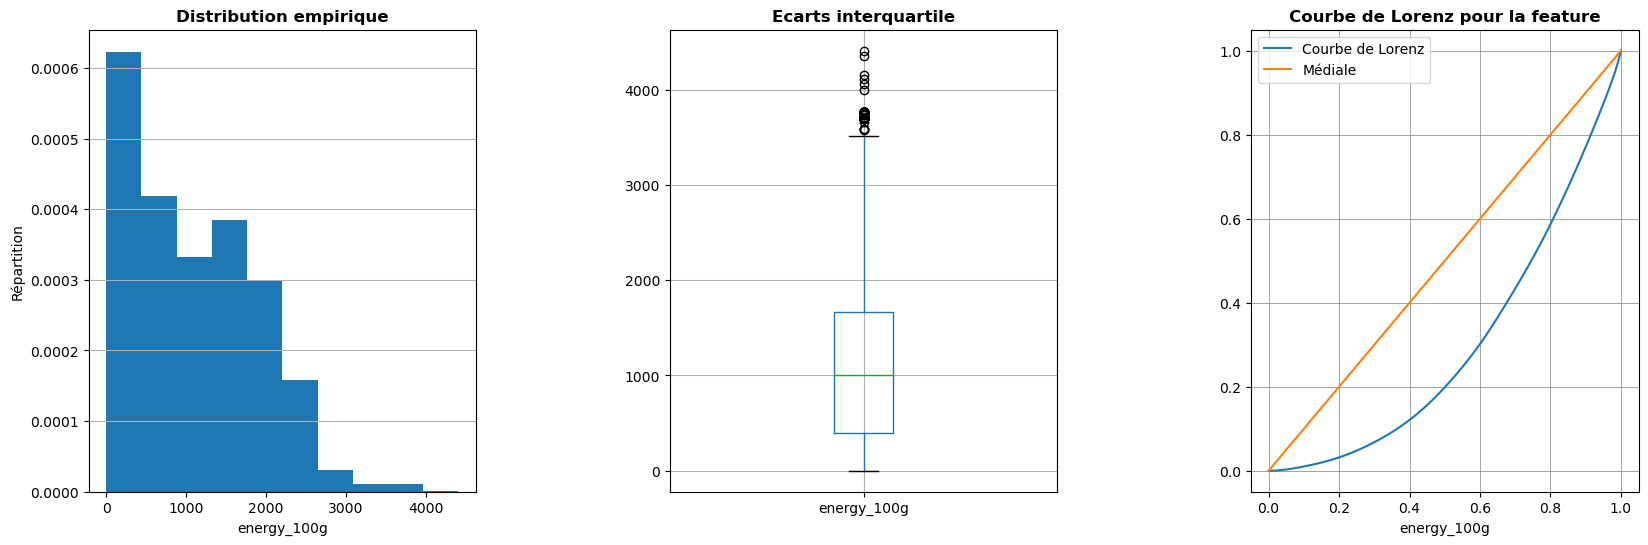

            Valeurs des statistiques
Mode                      201.000000
Moyenne                  1098.690028
Médiane                  1003.000000
Variance               607162.666864
Ecart type                779.206434
Skewness                    0.548741
Kurtosis                   -0.408760


------------------------------------------------
     Analyse de la feature fat_100g
------------------------------------------------


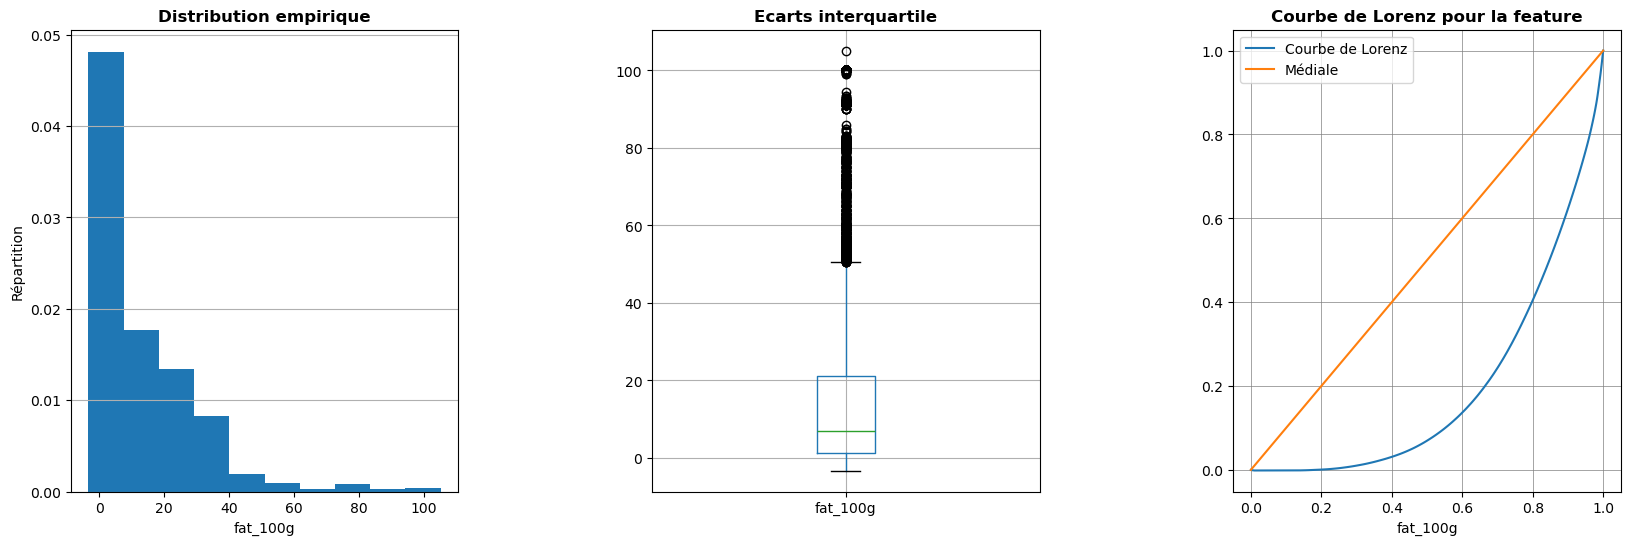

            Valeurs des statistiques
Mode                        0.000000
Moyenne                    13.093090
Médiane                     6.800000
Variance                  267.908858
Ecart type                 16.367922
Skewness                    2.148277
Kurtosis                    6.339648


------------------------------------------------
     Analyse de la feature saturated-fat_100g
------------------------------------------------


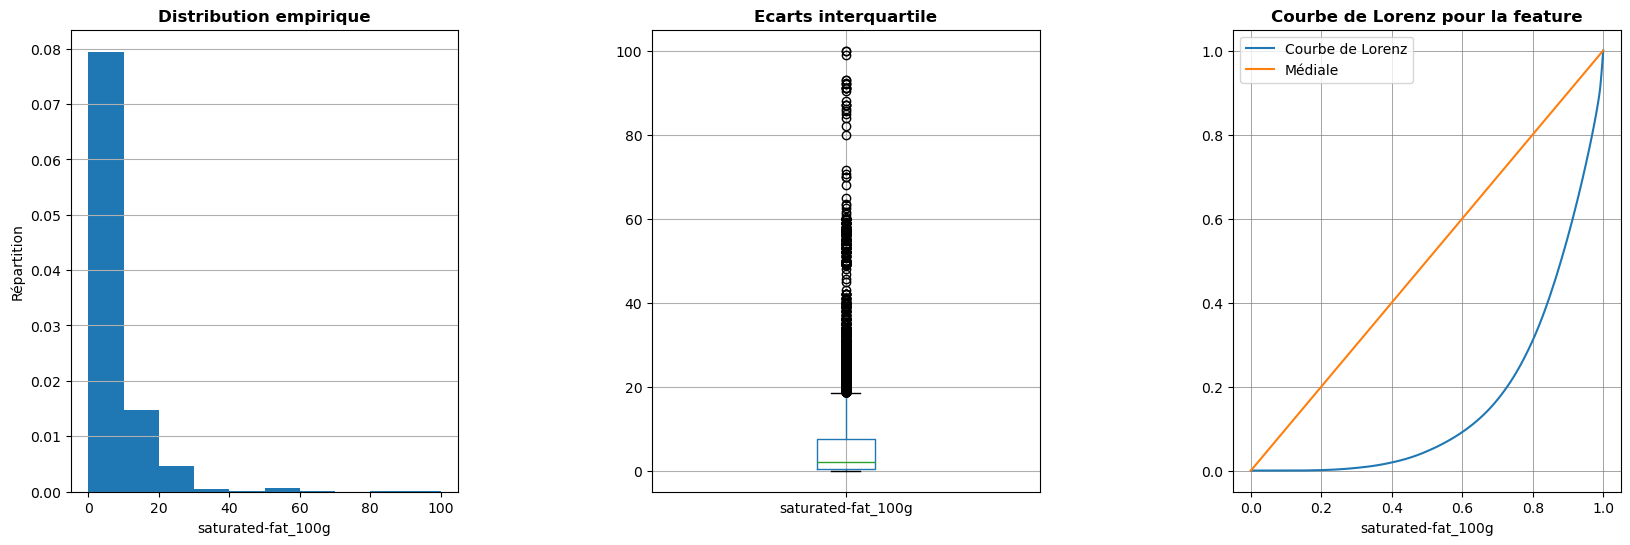

            Valeurs des statistiques
Mode                        0.000000
Moyenne                     5.457054
Médiane                     2.000000
Variance                   68.332090
Ecart type                  8.266323
Skewness                    3.085682
Kurtosis                   15.843292


------------------------------------------------
     Analyse de la feature carbohydrates_100g
------------------------------------------------


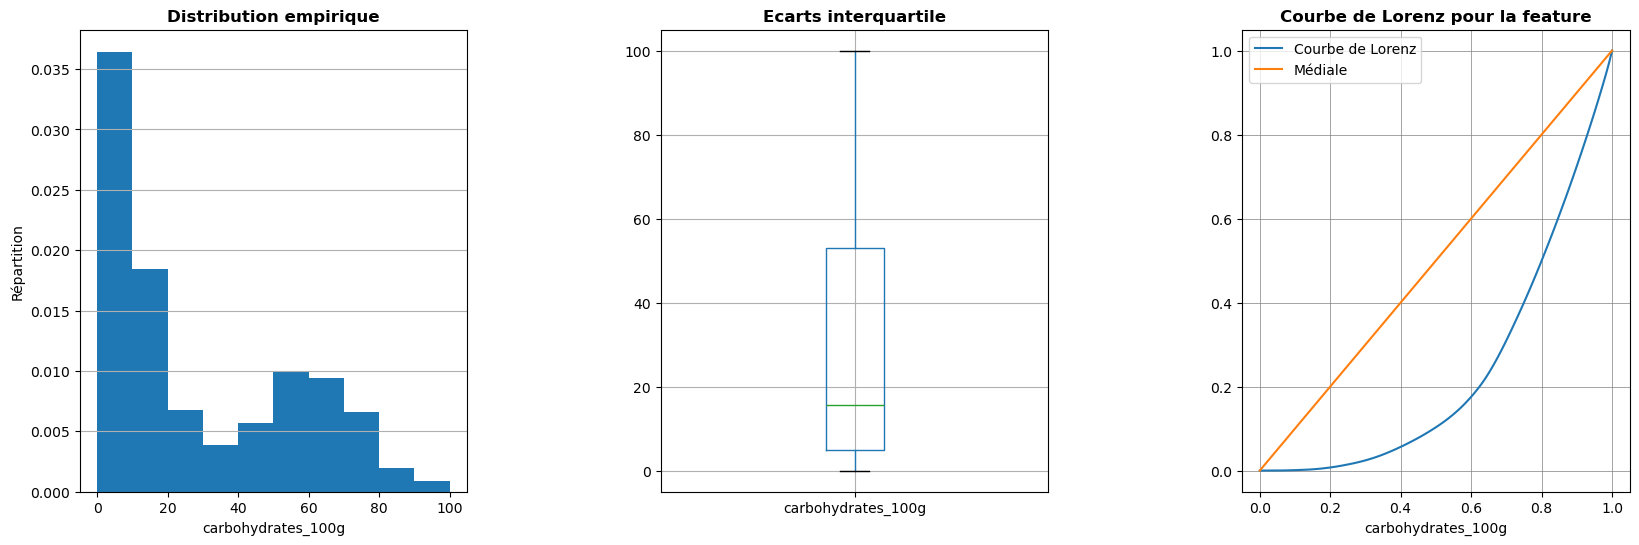

            Valeurs des statistiques
Mode                        0.000000
Moyenne                    28.171442
Médiane                    15.500000
Variance                  721.674913
Ecart type                 26.864008
Skewness                    0.662360
Kurtosis                   -0.975752


------------------------------------------------
     Analyse de la feature sugars_100g
------------------------------------------------


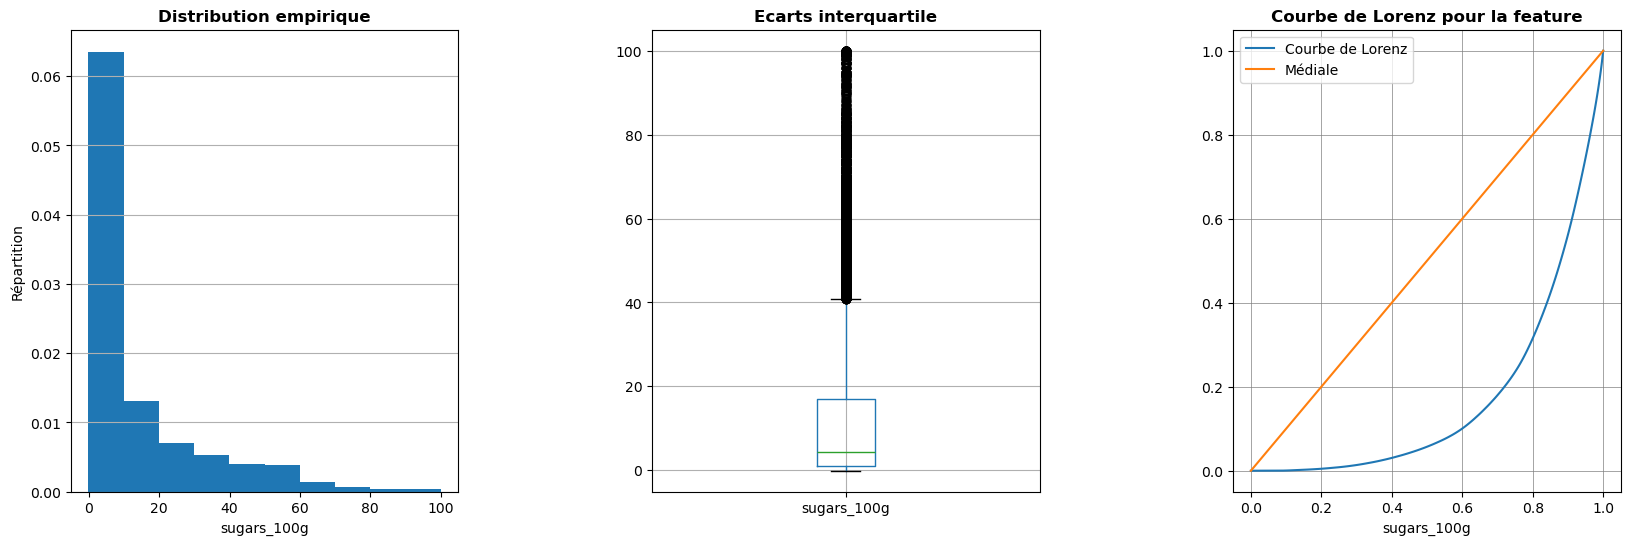

            Valeurs des statistiques
Mode                        0.000000
Moyenne                    13.087902
Médiane                     4.300000
Variance                  330.458614
Ecart type                 18.178521
Skewness                    1.887362
Kurtosis                    3.331999


------------------------------------------------
     Analyse de la feature fiber_100g
------------------------------------------------


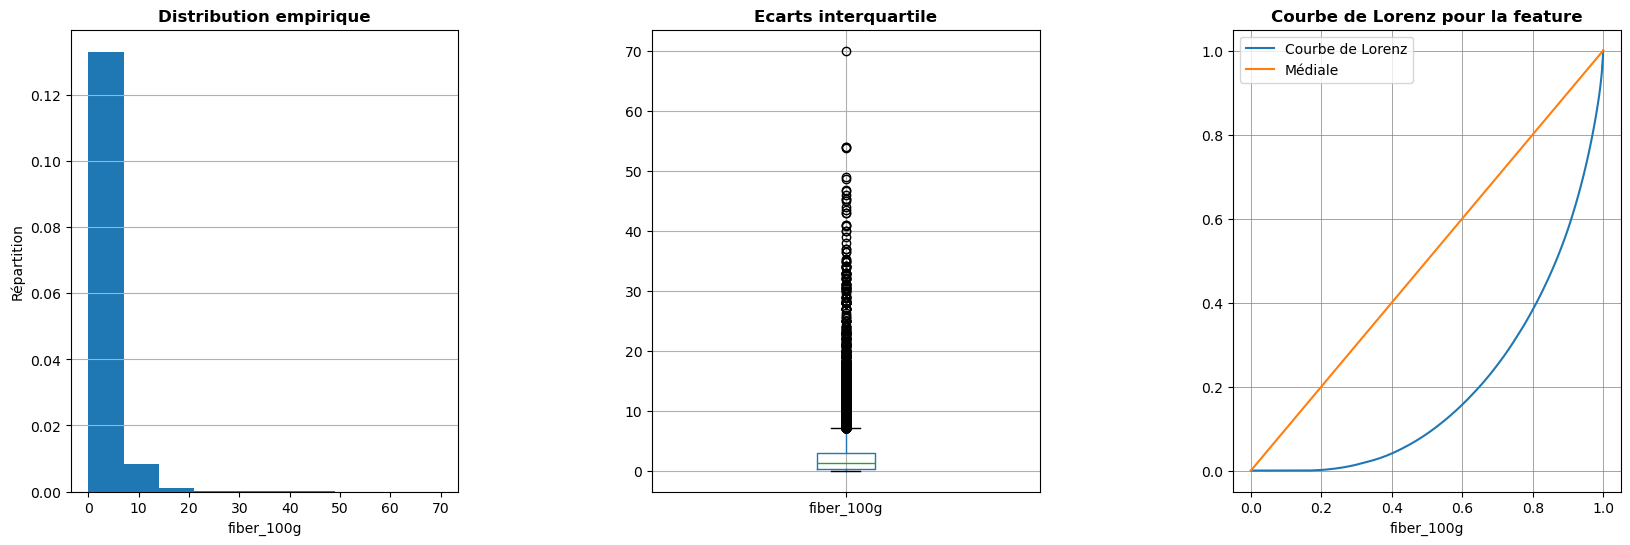

            Valeurs des statistiques
Mode                        0.000000
Moyenne                     2.258790
Médiane                     1.300000
Variance                   10.615919
Ecart type                  3.258208
Skewness                    4.475144
Kurtosis                   38.132627


------------------------------------------------
     Analyse de la feature proteins_100g
------------------------------------------------


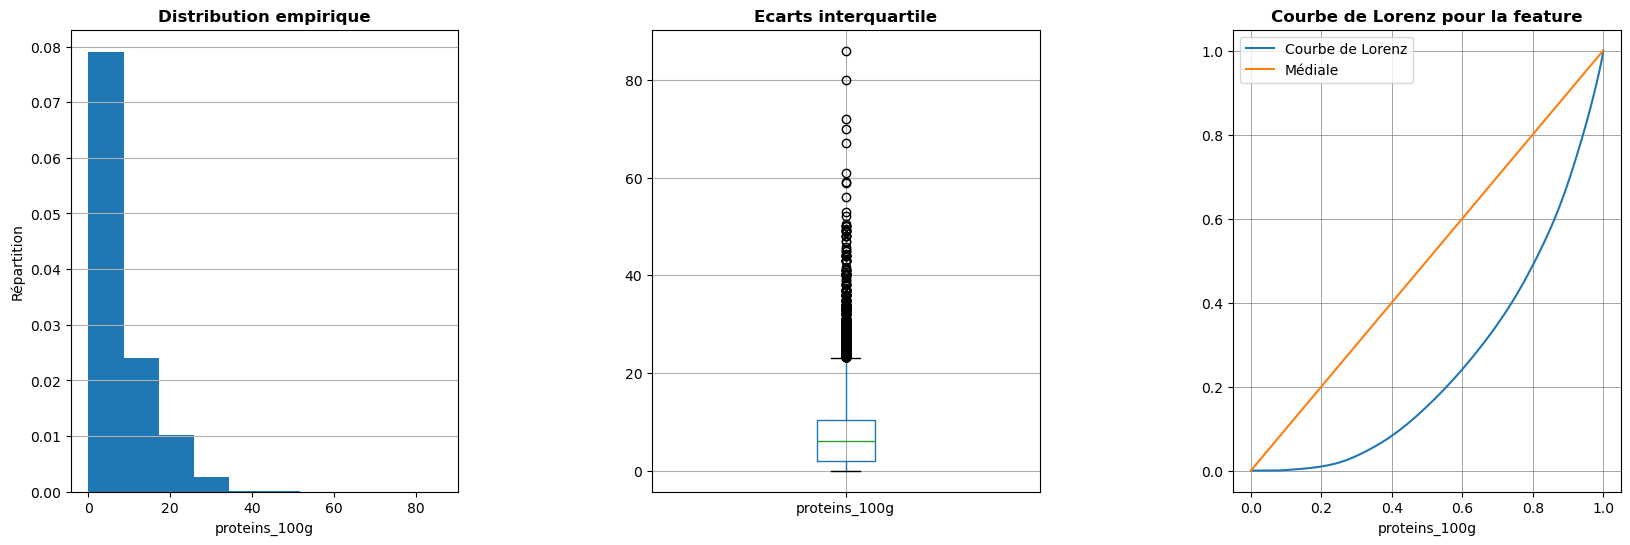

            Valeurs des statistiques
Mode                        0.000000
Moyenne                     7.502727
Médiane                     6.000000
Variance                   50.713841
Ecart type                  7.121365
Skewness                    1.469669
Kurtosis                    3.153794


------------------------------------------------
     Analyse de la feature salt_100g
------------------------------------------------


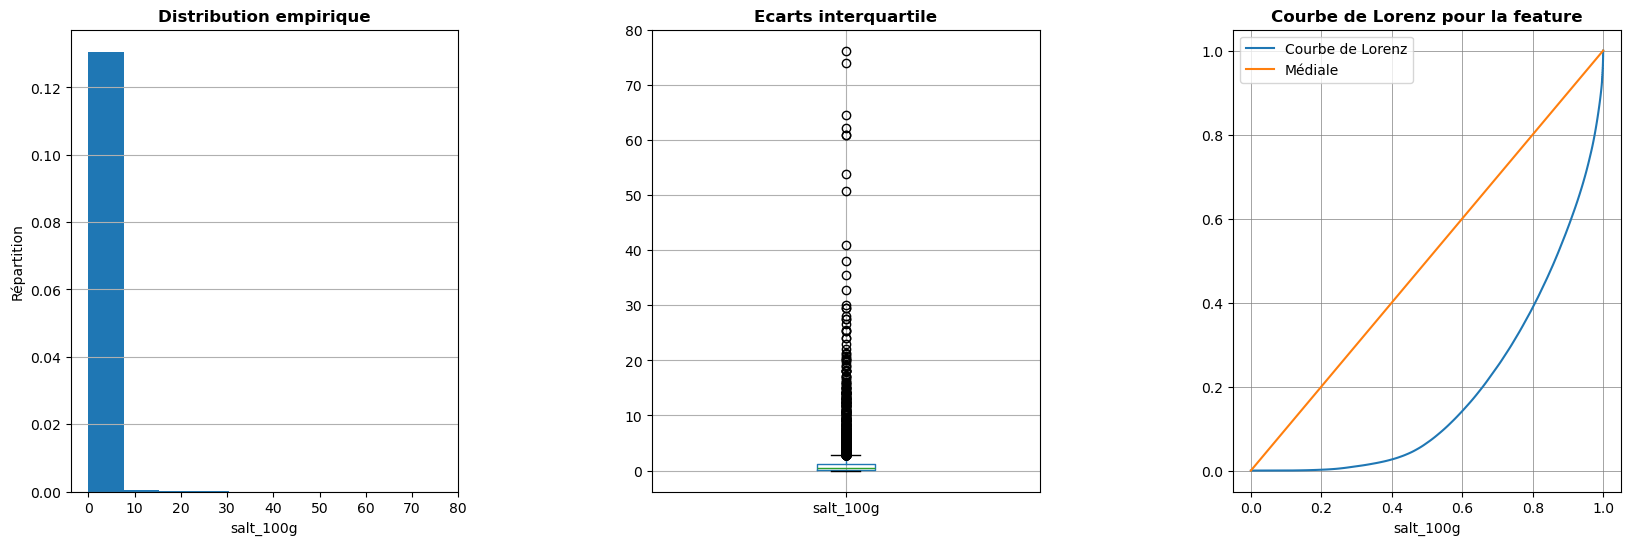

            Valeurs des statistiques
Mode                        0.000000
Moyenne                     0.851639
Médiane                     0.500000
Variance                    2.626060
Ecart type                  1.620512
Skewness                   16.586552
Kurtosis                  541.542012


------------------------------------------------
     Analyse de la feature sodium_100g
------------------------------------------------


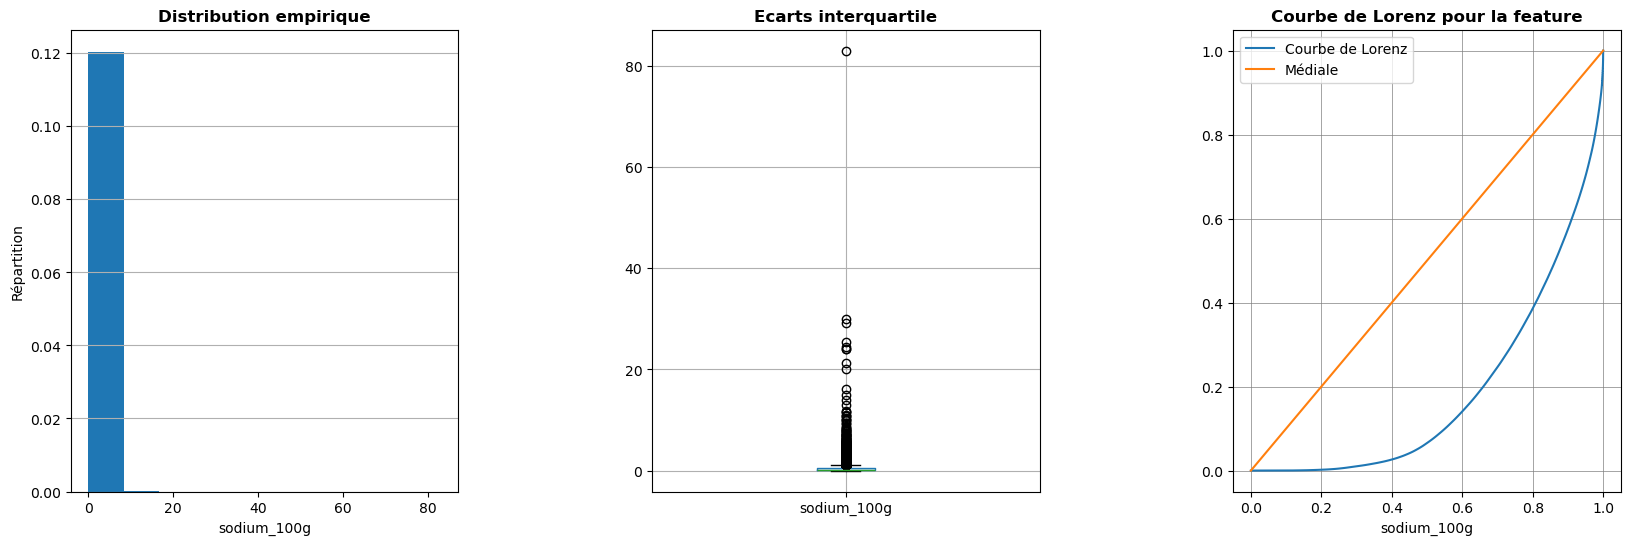

            Valeurs des statistiques
Mode                        0.000000
Moyenne                     0.337368
Médiane                     0.196850
Variance                    0.578646
Ecart type                  0.760688
Skewness                   42.002028
Kurtosis                 3768.012721


------------------------------------------------
     Analyse de la feature nutrition-score-fr_100g
------------------------------------------------


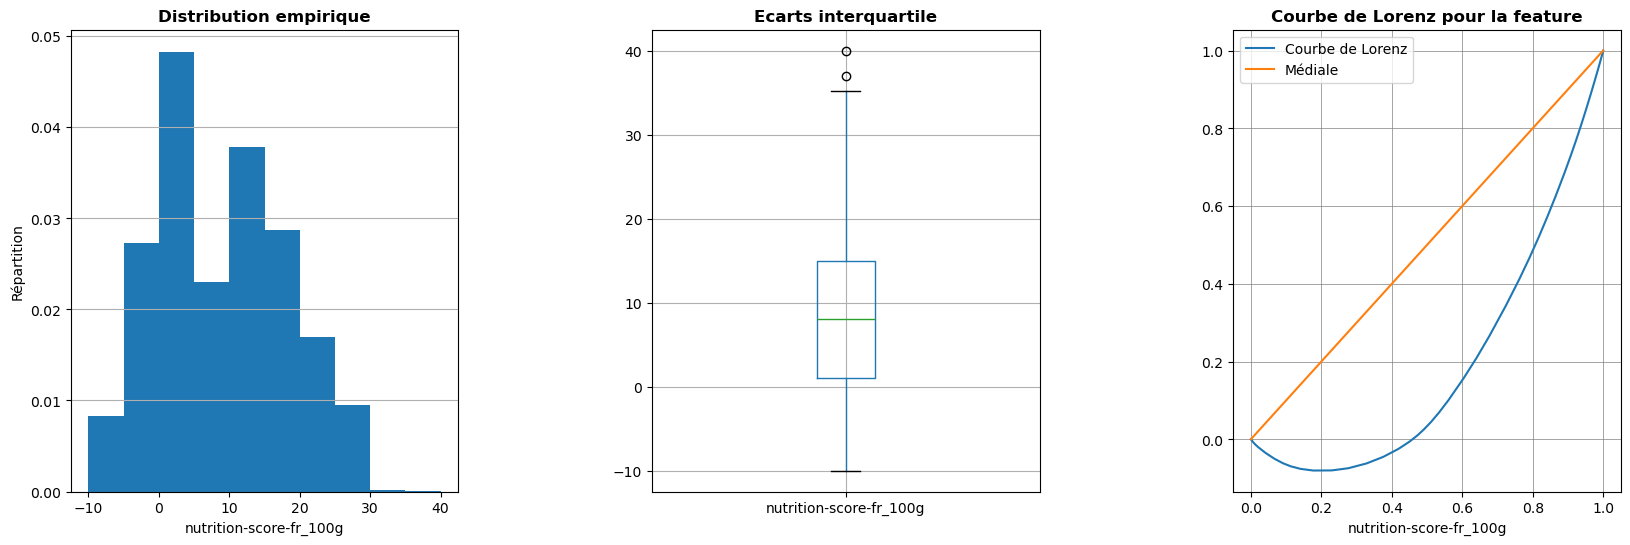

            Valeurs des statistiques
Mode                        2.000000
Moyenne                     8.401014
Médiane                     8.000000
Variance                   82.669208
Ecart type                  9.092261
Skewness                    0.209675
Kurtosis                   -0.907222




In [259]:
for feature in df_features :
    df_statistiques = calcule_statistiques(df_features, feature)
    print(df_statistiques)
    print("\n")